## Current Distribution Reconstruction

In [1]:
import numpy as np
import magpylib as magpy
import matplotlib as mpl
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from currio.utils import get_multipole_expansion_from_current_density
from currio.sensor import RegularGridSensor
from currio.compiled import get_b_njit

import magrec
from magrec.misc.sampler import GridSampler
from magrec.misc.plot import plot_vector_field_2d
from magrec.misc.plot import get_gridspec
from magrec.misc.plot import plot_n_components

### Functions

In [2]:
MM = 1e-3

def get_grid_multipole_expansion_time_3d_pad(current_density_series, pts,
                                        cell_size=None, grid_spec=None,
                                        volume_element=None, order=0):
    """
    Compute monopole expansion for each 3D cell (voxel) from time series of current densities. 

    Inputs:
    - current_density_series: (N, 3, T) array, current density at each point over time
    - pts: (N, 3) array, point coordinates
    - grid_spec (optional): (nx, ny, nz) number of cells along each axis
    - cell_size (optional): (dx, dy, dz) size of each cell
    - volume_element: float, volume per sample

    Outputs:
    - grid_monopoles_series: (nx, ny, nz, T, 3)
    - grid_centers_series: (nx, ny, nz, T, 3) centers repeated along time
    """

    _, _, T = current_density_series.shape

    if (grid_spec is None and cell_size is None) or (grid_spec is not None and cell_size is not None):
        raise ValueError("Provide either grid_spec or cell_size, not both.")

    xs, ys, zs = pts[:, 0], pts[:, 1], pts[:, 2]
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    z_min, z_max = zs.min(), zs.max()
    Lx, Ly, Lz = x_max - x_min, y_max - y_min, z_max - z_min

    if grid_spec is not None:
        nx, ny, nz = grid_spec
        dx = Lx / nx
        dy = Ly / ny
        dz = Lz / nz
        xmin_p, xmax_p = x_min, x_max
        ymin_p, ymax_p = y_min, y_max
        zmin_p, zmax_p = z_min, z_max
    else:
        dx, dy, dz = cell_size

        nx = int(np.ceil(Lx / dx))
        ny = int(np.ceil(Ly / dy))
        nz = int(np.ceil(Lz / dz))

        # padded sizes
        Lx_pad, Ly_pad, Lz_pad = nx * dx, ny * dy, nz * dz

        # symmetric padding
        pad_x = 0.5 * (Lx_pad - Lx)
        pad_y = 0.5 * (Ly_pad - Ly)
        pad_z = 0.5 * (Lz_pad - Lz)

        xmin_p, xmax_p = x_min - pad_x, x_max + pad_x
        ymin_p, ymax_p = y_min - pad_y, y_max + pad_y
        zmin_p, zmax_p = z_min - pad_z, z_max + pad_z


    # Edges and centers
    x_edges = np.linspace(xmin_p, xmax_p, nx + 1)
    y_edges = np.linspace(ymin_p, ymax_p, ny + 1)
    z_edges = np.linspace(zmin_p, zmax_p, nz + 1)

    grid_centers = np.zeros((nx, ny, nz, 3))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                grid_centers[i, j, k, 0] = 0.5 * (x_edges[i] + x_edges[i+1])
                grid_centers[i, j, k, 1] = 0.5 * (y_edges[j] + y_edges[j+1])
                grid_centers[i, j, k, 2] = 0.5 * (z_edges[k] + z_edges[k+1])

    grid_monopoles_series = np.zeros((nx, ny, nz, T, 3))
    grid_centers_series = np.repeat(grid_centers[:, :, :, np.newaxis, :], T, axis=3)

    for t in range(T):
        J_t = current_density_series[:, :, t]  # (N, 3)
        for i in range(nx):
            for j in range(ny):
                for k in range(nz):
                    mask = (
                        (xs >= x_edges[i]) & (xs <= x_edges[i+1]) &
                        (ys >= y_edges[j]) & (ys <= y_edges[j+1]) &
                        (zs >= z_edges[k]) & (zs <= z_edges[k+1])
                    )
                    if np.any(mask):
                        r0_cell = grid_centers[i, j, k, :]
                        N = np.count_nonzero(mask)
                        #delta_V = volume_element / N
                        grid_monopoles_series[i, j, k, t, :] = get_multipole_expansion_from_current_density(
                            J_t[mask], pts[mask], volume_element=volume_element, order=order, r0=r0_cell
                        )

    return grid_monopoles_series, grid_centers_series

def interpolate_slice_for_viz(pts, J, z_star, Nx=201, Ny=201, method='linear',
                              pad=0.0):
    """
    Interpolate scattered J(x,y,z) at fixed z=z_star onto a regular (Nx,Ny) grid
    for visualization. Physics should still use the scattered data.

    Inputs:
      pts : (N,3)
      J   : (N,3,1) or (N,3)
      z_star : z-slice (meters)
      Nx,Ny : output grid size
      method: 'linear' | 'cubic' | 'nearest' (for griddata)
      pad   : extra margin (meters) around [min,max] box for the grid

    Returns:
      X,Y : (Ny,Nx) meshgrid (indexing='xy')
      Jgrid : (3, Ny, Nx) interpolated components (NaN where outside hull)
    """
    pts = np.asarray(pts, float)
    J   = np.asarray(J,   float)
    if J.ndim == 3 and J.shape[2] == 1:
        J = J[..., 0]

    # filter points closest to z_star (tolerant slice)
    z = pts[:,2]
 
    z_levels = np.unique(np.round(z, 12))
    z0 = z_levels[np.argmin(np.abs(z_levels - z_star))]
    mask = np.isclose(z, z0, atol=1e-12)

    xy = pts[mask, :2]
    Jslice = J[mask, :]

    if xy.shape[0] < 3:
        raise ValueError("Not enough points at this z-slice to interpolate.")

    xmin, xmax = xy[:,0].min(), xy[:,0].max()
    ymin, ymax = xy[:,1].min(), xy[:,1].max()

    xg = np.linspace(xmin - pad, xmax + pad, Nx)
    yg = np.linspace(ymin - pad, ymax + pad, Ny)
    X, Y = np.meshgrid(xg, yg, indexing='xy')

    Jgrid = np.empty((3, Ny, Nx), dtype=float)
    for k in range(3):
        Jgrid[k] = griddata(xy, Jslice[:,k], (X, Y), method=method)

    return X, Y, Jgrid

def rescale_centers_to_index(grid_centers_xy, x_vals, y_vals, *, origin_lower=True, clip=True):
    """
    Map physical (x,y) centers to image index space [0..nx-1]x[0..ny-1]. The plot is given in the index space rather than in cartesian coordinates

    grid_centers_xy : (..., 2) array with [x, y] per center (slice already chosen).
    x_vals, y_vals  : 1D arrays of the coordinates used in the grid.
    origin_lower    : True if the plot has origin='lower' (matplotlib default for imshow with origin='lower'), otherwise False.
    """
    xs_unique = np.asarray(x_vals)
    ys_unique = np.asarray(y_vals)
    if xs_unique.size == 0 or ys_unique.size == 0:
        raise ValueError("x_vals / y_vals are empty")
    nx, ny = len(xs_unique), len(ys_unique)

    x_min, x_max = xs_unique.min(), xs_unique.max()
    y_min, y_max = ys_unique.min(), ys_unique.max()
    dx = (x_max - x_min)
    dy = (y_max - y_min)

    gc = np.asarray(grid_centers_xy, dtype=float).copy()
    # x index grows left→right
    gc[..., 0] = (gc[..., 0] - x_min) / dx * (nx - 1)

    # y index: choose direction based on plotting origin
    if origin_lower:
        # y increases bottom→top (imshow(origin='lower'))
        gc[..., 1] = (gc[..., 1] - y_min) / dy * (ny - 1)
    else:
        # y increases top→bottom
        gc[..., 1] = (y_max - gc[..., 1]) / dy * (ny - 1)

    if clip:
        gc[..., 0] = np.clip(gc[..., 0], 0, nx - 1)
        gc[..., 1] = np.clip(gc[..., 1], 0, ny - 1)
    return gc

def index_grid_centers(centers_flat, nx, ny, one_based=True):
    """
    centers_flat : (N,3) array of grid centers (N=nx*ny), already covering the rectangular grid.
    nx, ny       : grid dimensions
    one_based    : if True, keys in the dictionary are (1..nx, 1..ny).

    Returns:
      centers_idxed : ndarray shape (nx, ny, 3) with coordinates
      lookup        : dict mapping (row,col) -> (x,y,z)
    """
    centers = centers_flat.reshape(nx, ny, 3)  # assumes they were generated row by row
    lookup = {}
    for i in range(nx):
        for j in range(ny):
            key = (i+1, j+1) if one_based else (i, j)
            lookup[key] = tuple(centers[i, j])
    return centers, lookup

CBAR_PORTION = 0.05  # portion of width allocated to each colorbar

def get_gridspec_colormap_plot_colormap():
    """
    Returns a GridSpec with 3 columns: colormap1 | plot | colormap2
    """
    return gridspec.GridSpec(
        nrows=1, 
        ncols=3,
        width_ratios=[CBAR_PORTION, 1, CBAR_PORTION],
        wspace=0.1
    )

def plot_vector_field_2d_monopoles(current_distribution, grid_monopoles, grid_centers, ax: plt.Axes = None, 
                         interpolation='none', cmap='plasma', monopole_cmap='viridis' ,color='black', units=None,
                         units_mono=None, title=None, show=False, num_arrows=20, zoom_in_region=None):
    """
    Visualizes the current distribution in 2D as a heatmap of magnitudes and arrows representing the flow direction.
    On top of the heatmap, the monopoles are plotted with direction given by the components and magnitude by the colormap
    
    Parameters:
    ----------
    current_distribution : ndarray
        An array of shape (2, W, H) representing current distribution vectors.

    grid_monopoles : ndarray
        An array of shape (n_columns, n_rows, 3) representing the monopoles computed for each element in the grid

    grid_centers : ndarray
        An array of shape (n_columns, n_rows, 2), representing the coordinates for the centers of each element in the grid
    
    interpolation : str, optional
        The interpolation method to be used for the heatmap. Options are as provided by matplotlib's `imshow`.
        Default is 'none'.
    
    cmap : str, optional
        The colormap to be used for the heatmap. Options are as provided by matplotlib's colormaps.
        Default is 'plasma'.

    monopole_cmap : str, optional
        The colormap to be used for the monopoles magnitude. Options are as provided by matplotlib's colormaps.
        Default is 'viridis'.

    The 'inferno' & 'cool' combination provides ease of view for the quivers with respect to the background. 
        
    color : str, optional
        The color of the arrows. Default is 'black'.
            
    units : str, optional
        Show units on the colorbar for the current distribution. Default is None (no units).

    units_mono : str, optional
        Show units on the colorbar for the monopoles magnitude. Default is None (no units).
        
    title: str, optional
        Title of the plot. Default is None (no title).
    
    show : bool, optional
        If True, the plot is displayed using `plt.show()`. Otherwise, the plot is returned without being shown.
        Default is False.
    
    num_arrows : int, optional
        The approximate number of arrows to be used for the quiver plot across the width of the image.
        The function will adjust the number of arrows to avoid overcrowding. Default is 20.
    
    zoom_in_region : tuple of two tuples, optional
        A tuple representing the top-left and bottom-right corners of the rectangle for the inset. The format is 
        ((index_x_origin, index_y_origin), (index_x_diagonal, index_y_diagonal)). If provided, the function will render 
        the specified inset region with an arrow indicating the average flow direction. Default is None.
    
    Returns:
    -------
    fig : Figure
        A matplotlib figure containing the visualizations.

    Notes:
    -----
    - The main visualization provides a heatmap of the magnitudes and arrows indicating the flow direction of the 
      current distribution, and on top of that the arrows for the monopoles computed are plotted with the magnitude given by the colormap.
    - The inset, if specified, provides a zoomed-in view of a particular region of the main visualization, allowing for 
      a closer inspection of details.

    Examples:
    --------
    >>> dist = np.random.rand(2, 100, 100)
    >>> fig = plot_vector_field_2d(dist, interpolation='bilinear', cmap='inferno', show=True, num_arrows=30, inset_region=((20, 20), (40, 40)))
    """  
    # PARAMS
    # figsize = get_figsize(n_components=1, n_maps=1, alignment='horizontal')
    
    # Create a figure with an axis if none is provided
    if ax is None:
        fig = plt.figure(frameon=False)
        gs = get_gridspec_colormap_plot_colormap()

        # Main plot
        ax = fig.add_subplot(gs[1])

        # Main plot position
        ax_pos = ax.get_position()

        # Customization parameters
        cbar_height_ratio = 0.7  
        cbar_width = 0.03      
        cbar_padding = 0.1    

        # The colorbars are positioned with respect to the center of the plot
        ax_center_y = ax_pos.y0 + 0.5 * ax_pos.height
        cbar_height = ax_pos.height * cbar_height_ratio
        cbar_bottom = ax_center_y - 0.5 * cbar_height

        left_cbar_x = ax_pos.x0 - cbar_width - cbar_padding
        cax_left = fig.add_axes([left_cbar_x, cbar_bottom, cbar_width, cbar_height])

        right_cbar_x = ax_pos.x1 + cbar_padding
        cax_right = fig.add_axes([right_cbar_x, cbar_bottom, cbar_width, cbar_height])
    else:
        fig = ax.get_figure()
        try:
            cax_right = ax.cax2
            cax_left = ax.cax1
        except AttributeError:
            divider = make_axes_locatable(ax)
            cax_right = divider.append_axes("right", size="5%", pad=0.05)
            cax_left = divider.append_axes("left", size="5%", pad=0.05)

        
    if isinstance(current_distribution, torch.Tensor):
        current_distribution = current_distribution.detach().cpu().numpy()
        
    W, H = current_distribution.shape[-2:]
    step_size = max(W, H) // num_arrows
    
    # Create averaged grid
    x_centers = np.arange(step_size // 2, W, step_size)
    y_centers = np.arange(step_size // 2, H, step_size)
    
    x_grid, y_grid = np.meshgrid(x_centers, y_centers, indexing='ij')
    
    # Initialize averaged fields
    avg_u = np.zeros((len(x_centers), len(y_centers)))
    avg_v = np.zeros((len(x_centers), len(y_centers)))
    avg_m = np.zeros((len(x_centers), len(y_centers)))
    
    # Loop through and average
    for i, x in enumerate(x_centers):
        for j, y in enumerate(y_centers):
            x_low, x_high = x - step_size // 2, x + step_size // 2 + 1
            y_low, y_high = y - step_size // 2, y + step_size // 2 + 1
            
            avg_u[i, j] = np.mean(current_distribution[0, x_low:x_high, y_low:y_high])
            avg_v[i, j] = np.mean(current_distribution[1, x_low:x_high, y_low:y_high])
            avg_m[i, j] = np.sqrt(avg_v[i, j] ** 2 + avg_u[i, j] ** 2)
    
    magnitudes = np.hypot(current_distribution[0], current_distribution[1]).transpose(1, 0)
    
    im = ax.imshow(magnitudes, interpolation=interpolation, vmin=0, cmap=cmap, origin='lower')
    
    cbar = fig.colorbar(im, cax=cax_left, orientation='vertical')
    cax_left.yaxis.set_ticks_position('left')
    cax_left.yaxis.set_label_position('left')
    if units:
        cax_left.set_title(f"Current field [{units}]", fontsize=9, loc='center')
        
    if title:
        if isinstance(title, str):
            # Use .annotate() method to add the title text at the top of the figure
            ax.annotate(title, xy=(0.5, 1.1), xycoords='axes fraction',
                        xytext=(0, 0), textcoords='offset points',
                        ha='center', va='baseline')
    
    # Compute scale of the arrow length. 
    # Scale gives number of data points per arrow length unit, 
    # e.g. A/mm^2 per plot width. We want the maximum arrow length to be 1/num_arrows of the plot width.
    # How much data units per arrow length unit? 
    scale = 1.1 * avg_m.max() * num_arrows  # 1.1 to make the length of the longest arrow a bit shorter 
                                            # than the spacing between arrows blocks.  
    
    ax.quiver(
        x_grid, y_grid, avg_u, avg_v, color=color,
        pivot='mid', units='width', angles='uv',
        scale=scale, scale_units='width',
    )
    
    # --- Monopole Quivers ---
    X = grid_centers[:, :, 0].flatten()
    Y = grid_centers[:, :, 1].flatten()
    U = grid_monopoles[:, :, 0].flatten()
    V = grid_monopoles[:, :, 1].flatten()
    W = grid_monopoles[:, :, 2].flatten()
    magnitudes_mono = np.sqrt(U**2 + V**2 + W**2)

    # To avoid overcrowding of the plot, the quivers for the monopoles direction have a length that is half the distance with the nearest 
    # element of the cell
    dx = np.mean(np.diff(grid_centers[:, 0, 0]))  
    dy = np.mean(np.diff(grid_centers[0, :, 1]))  

    spacing = min(dx, dy)

    # Normalize direction
    norms_xy = np.sqrt(U**2 + V**2)
    U_norm = np.divide(U, norms_xy, out=np.zeros_like(U), where=norms_xy != 0)
    V_norm = np.divide(V, norms_xy, out=np.zeros_like(V), where=norms_xy != 0)

    # Fixed arrow length
    arrow_length = spacing * 0.5 # The value can be tweaked according to preference
    U_fixed = U_norm * arrow_length
    V_fixed = V_norm * arrow_length

    # Plot arrows e
    q = ax.quiver(
        X, Y, U_fixed, V_fixed, magnitudes_mono,
        cmap=monopole_cmap,
        scale_units='xy',  
        scale=1,          
        width=0.004,
        headlength=6,
        headaxislength=5,
        headwidth=4
)

    
    cb2 = fig.colorbar(q, cax=cax_right, orientation='vertical')
    if units_mono:
        cax_right.set_title(f"Monopole [{units_mono}]", fontsize=9, loc='center')

    if zoom_in_region is not None:
        x0, y0 = zoom_in_region[0]
        x1, y1 = zoom_in_region[1]
        axins = inset_axes(ax, width="30%", height="30%", loc='upper left')
        axins.imshow(magnitudes[x0:x1, y0:y1], cmap=cmap, origin='lower')
        
        axins.set_xticks([])
        axins.set_yticks([])
        
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    
    if not show:
        plt.close()
        
    return fig

def get_b_from_monopoles_to_grid(grid_centers_series, grid_monopole_series, obs_pts, Nx, Ny):
    """
    Computes the magnetic field from the monopoles
    
    Inputs: 
    - grid_centers_series : ndarray, array of size (nx, ny, nz, T, 3). 
    - grid_monopole_series: ndarray, array of size (nx, ny, nz, T, 3).
    - obs_pts : ndarray, array of size (Nx*Ny, 3), sensor grid points (time-independent)
    
    Output:
    - B_grid : ndarray, array of size (3, Nx, Ny, T), magnetic field in T
    """

    MU0_OVER_4PI = 1e-7
    nx, ny, nz, T, _ = grid_monopole_series.shape
    N = nx * ny * nz
    M = obs_pts.shape[0]
    assert M == Nx*Ny, "obs_pts must match Nx*Ny"

    # Flatten sources to (N, T, 3)
    m_flat  = grid_monopole_series.reshape(N, T, 3)
    r0_flat = grid_centers_series.reshape(N, T, 3)

    # Centers are constant over time so grid_center_series(t0)=grid_center_series(t)

    R = obs_pts[None, :, :] - r0_flat[:, 0, :][:, None, :]   # (N, M, 3)
    R2  = np.sum(R*R, axis=2)                                # (N, M)
    R32 = (R2) * np.sqrt(R2)                                 # (N, M)

    B = np.empty((M, 3, T), dtype=m_flat.dtype)
    for t in range(T):
        mt = m_flat[:, t, :]                                 # (N, 3)
        m_cross_R = np.cross(mt[:, None, :], R, axis=2)      # (N, M, 3)
        Bt = (m_cross_R / R32[..., None]).sum(axis=0)        # (M, 3)
        B[:, :, t] = MU0_OVER_4PI * Bt

    return B.transpose(1,0,2).reshape(3, Nx, Ny, T)

def grid_graph_from_monopoles(grid_centers):
    """
    Build upright square lattice (grid graph) connections from a static 2D grid of 3D points. Assume they are sorted. The grid is generated as the
    cartesian graph product of the path graphs

    Input:
    - grid_centers: ndarray, array of size (n_rows, n_cols, n_frames, 3). Grid of static 3D points.

    Output:
    - edges: list of ((x1, y1, z1), (x2, y2, z2)) tuples. Edges connecting each point to its right and top neighbors.
    """
    
    n_rows, n_cols, _, _ = grid_centers.shape
    edges = []
    
    # Only use frame 0 since all are equal
    grid = grid_centers[:, :, 0, :]

    for i in range(n_rows):
        for j in range(n_cols):
            p = grid[i, j]

            # Right neighbor
            if j + 1 < n_cols:
                p_right = grid[i, j + 1]
                edges.append((p, p_right))
            
            # Top neighbor
            if i + 1 < n_rows:
                p_top = grid[i + 1, j]
                edges.append((p, p_top))
    
    return edges

def draw_roi_box(fig, bounds_phys, full_bounds_phys,
                 color='white', lw=1.5, ls='--', alpha=0.95, mark_center=True):
    """
    Overlay a rectangle for a physical ROI on the first axes of `fig` whose image
    is drawn in INDEX space.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
    bounds_phys : (xmin, xmax, ymin, ymax) in meters   # from roi_from_two_coords(...)
    full_bounds_phys : (Xmin, Xmax, Ymin, Ymax) meters # the physical area shown by imshow
    color, lw, ls, alpha : styling
    mark_center : if True, put a dot at the ROI center

    Returns
    -------
    ax, idx_box : (Axes, (x0i, x1i, y0i, y1i)) in index coordinates
    """
    if not fig.axes:
        raise RuntimeError("Figure has no axes. Did the plot function close it?")
    ax = fig.axes[0]
    if not ax.images:
        raise RuntimeError("No imshow image found on axes to infer index size.")

    # raster size in index space
    arr = ax.images[0].get_array()
    H, W = arr.shape

    # map physical → index coordinates
    xmin, xmax, ymin, ymax = bounds_phys
    Xmin, Xmax, Ymin, Ymax = full_bounds_phys
    x0i = (xmin - Xmin) * (W / (Xmax - Xmin))
    x1i = (xmax - Xmin) * (W / (Xmax - Xmin))
    y0i = (ymin - Ymin) * (H / (Ymax - Ymin))
    y1i = (ymax - Ymin) * (H / (Ymax - Ymin))
    idx_box = (x0i, x1i, y0i, y1i)

    # draw rectangle
    ax.plot([x0i, x1i, x1i, x0i, x0i],
            [y0i, y0i, y1i, y1i, y0i],
            color=color, lw=lw, ls=ls, alpha=alpha, zorder=12)

    if mark_center:
        cx_i = 0.5*(x0i + x1i)
        cy_i = 0.5*(y0i + y1i)
        ax.scatter([cx_i], [cy_i], s=30, c=color, zorder=13)

    fig.canvas.draw_idle()
    return ax, idx_box

def roi_from_center(p1, p2, half_size=2.5*MM):
    """
    p1, p2: (x,y,z) coordinates of opposite vertices
    half_size: half-size in meters
    """
    p1, p2 = np.array(p1[:2]), np.array(p2[:2])  # only x,y
    center = 0.5*(p1+p2)
    cx, cy = center
    xmin, xmax = cx - half_size, cx + half_size
    ymin, ymax = cy - half_size, cy + half_size
    return {
        'center': (cx, cy),
        'bounds': (xmin, xmax, ymin, ymax)
    }
    
def filter_edges_in_roi(edges, bounds):
    """Keep edges whose both endpoints lie inside ROI (meters)."""
    xmin, xmax, ymin, ymax = bounds
    def inside(p):
        return (xmin <= p[0] <= xmax) and (ymin <= p[1] <= ymax)
    kept = []
    for p, q in edges:
        p = tuple(np.asarray(p, float)); q = tuple(np.asarray(q, float))
        if inside(p) and inside(q):
            kept.append((p, q))
    return kept

def centers_in_roi_mask(centers, bounds):
    xmin, xmax, ymin, ymax = bounds
    X = centers[...,0]; Y = centers[...,1]
    return (X >= xmin) & (X <= xmax) & (Y >= ymin) & (Y <= ymax)

def plot_geometry(bounds, gcs_z0, edges,
                              dead_each=0.4e-3,
                              elev=28, azim=37, loops=None,
                              central_subsegment_func=None):
    """
    Plot slab, ROI grid centers, edges, and a list of circular current loops.
    Handles both 3D (N, N, 3) and 4D (Ny, Nx, N_frames, 3) center arrays.
    
    Args:
        bounds (tuple): (xmin, xmax, ymin, ymax, zmin, zmax)
        gcs_z0 (np.array): Center grid. Can be 3D or 4D.
        edges (list): List of edge segments.
        ... other args ...
        central_subsegment_func: Pass your central_subsegment function here.
    """
    xmin, xmax, ymin, ymax, zmin, zmax = bounds

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # ---- slab ----
    corners = np.array([
        [xmin, ymin, zmin],[xmax, ymin, zmin],[xmax, ymax, zmin],[xmin, ymax, zmin],
        [xmin, ymin, zmax],[xmax, ymin, zmax],[xmax, ymax, zmax],[xmin, ymax, zmax],
    ])
    faces = [[corners[j] for j in f] for f in
             [(0,1,2,3),(4,5,6,7),(0,1,5,4),(2,3,7,6),(1,2,6,5),(0,3,7,4)]]
    slab = Poly3DCollection(faces, facecolors='gray', linewidths=1,
                            edgecolors='gray', alpha=0.15)
    ax.add_collection3d(slab)

    # ---- grid points (frame 0) ----
    # UNIFIED LOGIC: Check dimensions to handle 3D (new) or 4D (old) input
    if gcs_z0.ndim == 4:
        # Original format: (Ny, Nx, N_frames, 3) -> take frame 0
        grid_points = gcs_z0[:, :, 0, :]
    elif gcs_z0.ndim == 3:
        # New format: (N, N, 3) -> use directly
        grid_points = gcs_z0
    else:
        raise ValueError(f"Input gcs_z0 array has unexpected dimension: {gcs_z0.ndim}. Expected 3 or 4.")
        
    ax.scatter(grid_points[...,0], grid_points[...,1], grid_points[...,2], c='#c64a25', s=14)

    # ---- Plotting the Edges (RE-ADDED) ----
    if edges is not None:
        for count, edge in enumerate(edges):
            ps, qs = edge[0], edge[1]

            # Apply trimming only if dead_each is specified AND the function is provided
            ps_trim, qs_trim = ps, qs
            if dead_each > 0:
                ps_trim, qs_trim = central_subsegment(ps, qs, dead_each=dead_each)
            
            ax.plot([ps_trim[0], qs_trim[0]], [ps_trim[1], qs_trim[1]], [ps_trim[2], qs_trim[2]], '#1e2a38', lw=2.0)
    
    # ---- Plotting the Loops ----
    if loops is not None:
        # ... (Loop plotting logic remains the same) ...
        for loop_info in loops:
            center_x = loop_info['center_x']
            center_y = loop_info['center_y']
            center_z = loop_info['center_z']
            radius = loop_info['radius']
            
            Nloop = 100
            theta = np.linspace(0, 2*np.pi, Nloop)
            x_loop = center_x + radius * np.cos(theta)
            y_loop = center_y + radius * np.sin(theta)
            z_loop = np.full_like(x_loop, center_z)
            
            ax.plot(x_loop, y_loop, z_loop, color='red', linewidth=2)
            ax.scatter(center_x, center_y, center_z, c='red', s=8, marker='o')

    # ---- axes ----
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
    ax.set_box_aspect([1,1,0.1])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')    
    
    plt.tight_layout()
    plt.show()
    return fig, ax

def _unit(v, fallback):
    n = np.linalg.norm(v)
    if n == 0.0:
        return np.array(fallback, dtype=float)
    return v / n

def build_equal_volume_prisms(edges_roi, dx, dy, zmin, zmax, dead_each=0.4e-3):
    """
    Build one rectangular prism per edge, centered at the active (trimmed) segment midpoint.
    Geometry (identical cross-section for all prisms):
      - length  = L_eff  (|central_subsegment|)
      - width   = cell width perpendicular to the edge (dy for horizontal, dx for vertical)
      - height  = slab thickness (zmax - zmin)
    Returns:
      prisms: list of dicts with keys:
        'p','q'        : original edge endpoints
        'ps','qs'      : trimmed endpoints (active subsegment)
        'center'       : midpoint of active subsegment
        't_hat'        : unit tangent (along edge)
        'n_perp'       : in-plane unit normal (perpendicular in xy)
        'L_eff'        : active length
        'half_width'   : width/2 (perpendicular in-plane)
        'half_thick'   : height/2 (z)
        'A_cross'      : cross-section area (width * height)
        'volume'       : A_cross * L_eff
        'orientation'  : 'h' (horizontal) or 'v' (vertical)
    """
    prisms = []
    height = float(zmax - zmin)
    half_thick = 0.5 * height

    for (p_raw, q_raw) in edges_roi:
        p = np.asarray(p_raw, float)
        q = np.asarray(q_raw, float)

        L_new = float(np.linalg.norm(q-p))

        # Active subsegment & length
        ps, qs = central_subsegment(p, q, dead_each=dead_each)
        e_act = qs - ps
        L_eff = float(np.linalg.norm(e_act))
        if L_eff == 0.0:
            # Degenerate; skip
            continue

        t_hat = _unit(e_act, fallback=[1,0,0])

        # Orientation & width (perpendicular cell size)
        horiz_like = abs(q[0] - p[0]) >= abs(q[1] - p[1])
        if horiz_like:
            width = float(dy)             # perpendicular to x-edge is y
            orientation = 'h'
        else:
            width = float(dx)             # perpendicular to y-edge is x
            orientation = 'v'
        half_width = 0.5 * width

        # In-plane perpendicular unit vector (xy)
        t_xy = t_hat.copy(); t_xy[2] = 0.0
        if np.allclose(t_xy, 0.0):
            n_perp = np.array([1.0, 0.0, 0.0], dtype=float)
        else:
            n_perp = _unit(np.array([-t_xy[1], t_xy[0], 0.0]), fallback=[1,0,0])

        center = 0.5 * (ps + qs)
        A_cross = width * height
        volume = A_cross * L_new

        prisms.append(dict(
            p=p, q=q, ps=ps, qs=qs,
            center=center,
            t_hat=t_hat, n_perp=n_perp,
            L_eff=L_eff,                   # placement length
            L_int=L_new,  
            half_width=half_width, half_thick=half_thick,
            A_cross=A_cross, volume=volume,
            orientation=orientation
        ))
    return prisms

def prism_corners_from_dict(pr):
    """Return (8,3) array of prism corners using fields in the prism dict."""
    import numpy as np
    c        = pr['center']
    t_hat    = pr['t_hat']
    n_perp   = pr['n_perp']
    z_hat    = np.array([0.0, 0.0, 1.0])
    Lh       = 0.5 * pr['L_int']
    a        = pr['half_width']
    b        = pr['half_thick']

    # local corners (u along t_hat, v along n_perp, w along ẑ)
    corners_local = np.array([
        [-Lh,-a,-b], [-Lh,-a,+b], [-Lh,+a,+b], [-Lh,+a,-b],
        [+Lh,-a,-b], [+Lh,-a,+b], [+Lh,+a,+b], [+Lh,+a,-b],
    ])
    T = np.vstack([t_hat, n_perp, z_hat]).T
    return c + corners_local @ T.T

def get_A_matrix(obs_pts, pcb_edges):
    """
    Builds the A matrix for the least-squares problem using get_b_njit.
    """
    N_ROI = obs_pts.shape[0]
    M = len(pcb_edges)
    A = np.zeros((3 * N_ROI, M), dtype=np.float64)
    current_unit_I = np.ones((1, 1), dtype=np.float64)

    for j, edge in enumerate(pcb_edges):
        r_start = np.array([edge[0]])
        r_end = np.array([edge[1]])
        current_pts_segment = np.concatenate((r_start, r_end), axis=0)

        B_field = get_b_njit(current_pts_segment, np.ascontiguousarray(obs_pts), current_unit_I)
        A_column = B_field.reshape(3 * N_ROI)
        A[:, j] = A_column

    return A

def generate_lcurve_data(A, B_truth_vector, lambda_vals):
    """
    Generates the data for the L-curve plot.
    Returns residual_norms and solution_norms.
    """
    residual_norms = []
    solution_norms = []

    for lambda_val in lambda_vals:
        A_reg = np.vstack([A, lambda_val * np.eye(A.shape[1])])
        B_reg = np.vstack([B_truth_vector, np.zeros((A.shape[1], 1))])
        
        I_solution, _, _, _ = np.linalg.lstsq(A_reg, B_reg, rcond=None)
        
        residual_norm = np.linalg.norm(A @ I_solution - B_truth_vector)**2
        solution_norm = np.linalg.norm(I_solution)**2
        
        residual_norms.append(residual_norm)
        solution_norms.append(solution_norm)
    
    return np.array(residual_norms), np.array(solution_norms)

def find_lcurve_corner(residual_norms, solution_norms, lambda_vals):
    """
    Finds the optimal lambda by locating the corner of the L-curve.
    
    Inputs:
    - residual_norms: array of the residual norms from the L-curve plot
    - solution_norms: array of the solution norms from the L-curve plot
    - lambda_vals: the array of lambda values used to generate the curve
    
    Output:
    - optimal_lambda: the lambda value at the corner
    """
    # Normalize the data for a fair comparison
    norm_residuals = residual_norms / np.max(residual_norms)
    norm_solutions = solution_norms / np.max(solution_norms)

    # Calculate the distance of each point from the origin (0, 0)
    distances = np.sqrt(norm_residuals**2 + norm_solutions**2)

    # Find the index of the point with the minimum distance
    optimal_idx = np.argmin(distances)

    return lambda_vals[optimal_idx]

def undirected_key(p, q):
    p_tuple = tuple(np.round(p, 6))
    q_tuple = tuple(np.round(q, 6))
    return frozenset([p_tuple, q_tuple])

def central_subsegment(p, q, dead_each=0.4*MM):
    """
    Return the central subsegment endpoints after trimming `dead_each` from both ends.
    """
    p = np.asarray(p, float); q = np.asarray(q, float)
    L = np.linalg.norm(q - p)
    if L <= 2*dead_each:
    	# degenerate; return mid-point segment of negligible length
        m = 0.5*(p+q)
        return m, m
    t0 = dead_each / L
    t1 = 1.0 - t0
    ps = p + t0*(q - p)
    qs = p + t1*(q - p)
    return ps, qs

def get_b_from_edges_to_grid(edges, edge_I, obs_pts, Nx, Ny):
    """
    Sum B from all segments using your original get_b_njit.
    - edges: oriented right/up (p->q)
    - edge_I: dict with signed current per *undirected* segment
    """
    P = obs_pts.shape[0]
    B_tot = np.zeros((3, P, 1), dtype=np.float64)
    pts_f = np.ascontiguousarray(obs_pts, dtype=np.float64)


    for p_raw, q_raw in edges:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)

        I = edge_I.get(undirected_key(p, q), 0.0)  # signed; keep geometry p->q
        if I == 0.0:
            continue

        # ensure the kernel sees current flowing first->second
        if I >= 0:
            current_pts = np.vstack([p, q]); I_use = I
        else:
            current_pts = np.vstack([q, p]); I_use = -I

        current = np.array([[I_use]], dtype=np.float64)    # (1,1)

        B_seg = get_b_njit(current_pts, pts_f, current)   # (3,P,1)
        B_tot += B_seg                        
    

    return B_tot[:, :, 0].reshape(3, Nx, Ny)

def get_b_from_edges_to_grid_roi(edges, edge_I_roi, obs_pts, Nx, Ny):
    """
    Sum B from all segments using get_b_njit.
    """
    P = obs_pts.shape[0]
    B_tot = np.zeros((3, P, 1), dtype=np.float64)
    pts_f = np.ascontiguousarray(obs_pts, dtype=np.float64)

    for p_raw, q_raw in edges:
        key = undirected_key(p_raw, q_raw)
        I = float(edge_I_roi.get(key, 0.0))
        if I == 0.0:
            continue
        
        ps, qs = central_subsegment(p_raw, q_raw, dead_each=0.4*MM)
        if I >= 0:
            current_pts = np.vstack([ps, qs]); I_use = I
        else:
            current_pts = np.vstack([qs, ps]); I_use = -I

        current = np.array([[I_use]], dtype=np.float64)
        B_seg = get_b_njit(current_pts, pts_f, current)
        B_tot += B_seg   

def calculate_area_fraction(B_reconstructed, B_truth, threshold=0.10, abs_threshold=2e-10):
    """
    Calculates the area fraction where the reconstruction is considered a "good fit."
    A good fit is defined as:
    1. Relative Error < threshold (e.g., 10%), OR
    2. Absolute Error < abs_threshold (e.g., sensor noise/resolution).

    B_reconstructed and B_truth must be of shape (3, N_pts), 
    where N_pts is the total number of observation points.
    """
    
    # B_rec and B_tru are expected to be (3, N_pts)
    N_pts = B_reconstructed.shape[1]
    
    # --- 1. Calculate Absolute Error ---
    abs_error = np.abs(B_reconstructed - B_truth) # Shape (3, N_pts)

    # --- 2. Calculate Stable Relative Error ---
    # Use the MAX magnitude of the TRUE field component as the denominator for stability.
    B_ref_x = np.max(np.abs(B_truth[0, :]))
    B_ref_y = np.max(np.abs(B_truth[1, :]))
    B_ref_z = np.max(np.abs(B_truth[2, :]))

    # Set references (denominators) for stability (avoid division by 0)
    ref_x = B_ref_x if B_ref_x > 1e-15 else 1.0
    ref_y = B_ref_y if B_ref_y > 1e-15 else 1.0
    ref_z = B_ref_z if B_ref_z > 1e-15 else 1.0

    # Calculate the Normalized Relative Error
    rel_error_x = abs_error[0, :] / ref_x
    rel_error_y = abs_error[1, :] / ref_y
    rel_error_z = abs_error[2, :] / ref_z

    # --- 3. Apply the Dual Threshold Condition (Good Fit Mask) ---
    
    # Bx Good Fit Mask
    good_fit_mask_x = (rel_error_x < threshold) | (abs_error[0, :] < abs_threshold)
    
    # By Good Fit Mask
    good_fit_mask_y = (rel_error_y < threshold) | (abs_error[1, :] < abs_threshold)
    
    # Bz Good Fit Mask
    good_fit_mask_z = (rel_error_z < threshold) | (abs_error[2, :] < abs_threshold)

    # --- 4. Calculate the Area Fraction ---
    area_fraction_x = np.sum(good_fit_mask_x) / N_pts
    area_fraction_y = np.sum(good_fit_mask_y) / N_pts
    area_fraction_z = np.sum(good_fit_mask_z) / N_pts

    return area_fraction_x, area_fraction_y, area_fraction_z

def generate_grid_geometry(bounds, N_centers_per_side, z_level):
    """
    Generates monopole centers and corresponding edges for a fixed-boundary grid graph.
    
    Args:
        bounds (tuple): (xmin, xmax, ymin, ymax)
        N_centers_per_side (int): Number of centers along the X and Y dimensions.
        z_level (float): Z-coordinate of the centers.
        
    Returns:
        tuple: (edges_roi, centers_grid)
               - edges_roi (list): list of segments in format [[[x1, y1, z1], [x2, y2, z2]], ...]
               - centers_grid (np.array): (N x N x 3) array of all center coordinates.
    """
    xmin, xmax, ymin, ymax = bounds
    
    # 1. Generate Centers (using linspace ensures corners are fixed)
    x_coords = np.linspace(xmin, xmax, N_centers_per_side)
    y_coords = np.linspace(ymin, ymax, N_centers_per_side)
    
    # 2D Grid of centers (N_centers_per_side x N_centers_per_side x 3)
    # Note: centers_grid[j, i, :] accesses center at (x_coords[i], y_coords[j])
    centers_grid = np.array([[[x, y, z_level] for x in x_coords] for y in y_coords])
    
    edges_roi = []
    
    # 2. Generate Edges
    N = N_centers_per_side
    
    # Horizontal edges (connecting (i, j) to (i+1, j))
    for j in range(N): 
        for i in range(N - 1): 
            p = centers_grid[j, i, :]
            q = centers_grid[j, i+1, :]
            edges_roi.append([p.tolist(), q.tolist()])
            
    # Vertical edges (connecting (i, j) to (i, j+1))
    for i in range(N): 
        for j in range(N - 1): 
            p = centers_grid[j, i, :]
            q = centers_grid[j+1, i, :]
            edges_roi.append([p.tolist(), q.tolist()])
            
    return edges_roi, centers_grid                    



### Data Import

In [3]:
plane_wave_data = np.loadtxt("/Users/ValerioDeSio/Desktop/PythonThesis/slab3D_J_uniform2.csv", delimiter=",")

x = plane_wave_data[:,0]*0.01
y = plane_wave_data[:,1]*0.01
z = plane_wave_data[:,2]
Jx = plane_wave_data[:,3]
Jy = plane_wave_data[:,4]
Jz = plane_wave_data[:,5]

pts = np.column_stack([x,y,z])
cds = np.stack([Jx, Jy, Jz], axis=1)[:, :, None]  # (N,3,1) -> T=1

# unique sorted coordinates
x_u = np.unique(np.round(pts[:,0], 12))
y_u = np.unique(np.round(pts[:,1], 12))
z_u = np.unique(np.round(pts[:,2], 12))

# grid spacings (robust: median of diffs)
dx = np.median(np.diff(x_u))
dy = np.median(np.diff(y_u))
dz = np.median(np.diff(z_u))

volume_element = dx*dy*dz

print(f"Mesh: {x_u.size} x {y_u.size} x {z_u.size} points")
print(f"Spacing between samples: {dx, dy, dz} m")

Mesh: 400 x 400 x 3 points
Spacing between samples: (np.float64(0.0001250000000000001), np.float64(0.0001250000000000001), np.float64(0.0001)) m


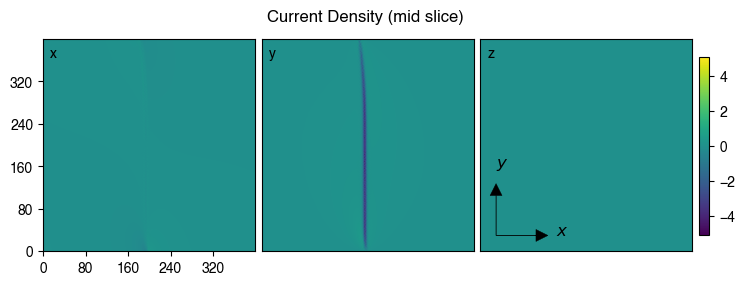

In [4]:
%matplotlib inline

z=1
samples = len(x_u)*len(y_u)
lb = z*samples 
ub = (z+1)*samples

plot_n_components(GridSampler.pts_to_grid(cds[lb:ub,:,0], 400, 400),title='Current Density (mid slice)')

ROI center (m): (np.float64(0.022975000000000006), np.float64(0.025675000000000007))
ROI bounds (m): (np.float64(0.020475000000000007), np.float64(0.025475000000000005), np.float64(0.023175000000000008), np.float64(0.028175000000000006))


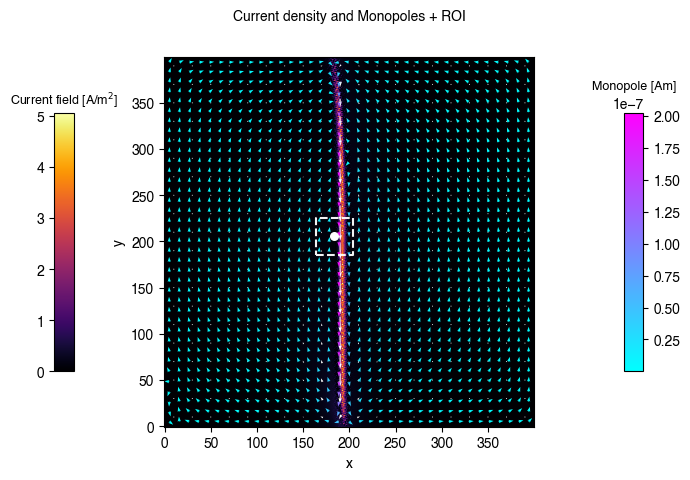

In [5]:
dx_s = dy_s = 1.35e-3
dz_s = max(z_u)

gds, gcs = get_grid_multipole_expansion_time_3d_pad(
    cds,
    pts,
    cell_size=(dx_s, dy_s, dz_s),  # 3D grid spec (x, y,z)
    # grid_spec=(5,5,1),
    volume_element=dx_s*dy_s*dz_s
)

# Mask for z=0.0001 plane (midplane)
mask_z0 = np.isclose(pts[:, 2], 0.0001, atol=1e-12)
# Apply mask
pts_z0 = pts[mask_z0]
cds_z0 = cds[mask_z0]  # shape: (N_z0, 3, T)
z_centers = gcs[:, :, :, 0, 2]
z_idx = np.where(np.isclose(z_centers[0, 0, :], 0.0001, atol=1e-12))[0]
z_idx = z_idx[0]
gds_z0 = gds[:, :, z_idx, :, :]
gcs_z0 = gcs[:, :, z_idx, :, :]

t_idx = 0 # Change according to the time step we evaluate
cds_t = cds_z0[:,:,t_idx]
gds_t = gds_z0[:,:,t_idx]
gcs_t = gcs_z0[:,:,t_idx]

z_star=0.0001  # mid-plane
X, Y, Jgrid = interpolate_slice_for_viz(pts, cds, z_star, Nx=400, Ny=400, method='linear')
xs_unique = X[0, :]   # length Nx
ys_unique = Y[:, 0]   # length Ny

# Your helper requires sorted unique arrays; ensure increasing order
xs_unique = np.asarray(xs_unique)
ys_unique = np.asarray(ys_unique)
current_distribution = np.stack([Jgrid[0].T, Jgrid[1].T], axis=0)  # (2, Nx, Ny)

grid_centers_idx = rescale_centers_to_index(gcs_t, xs_unique, ys_unique)

nx, ny = gcs_t.shape[:2]

# Build dictionary
centers_idxed, lookup = index_grid_centers(gcs_t.reshape(nx*ny,3), nx, ny, one_based=True)

p1 = lookup[(17,20)]
p2 = lookup[(18,19)]

roi = roi_from_center(p1, p2)
print("ROI center (m):", roi['center'])
print("ROI bounds (m):", roi['bounds'])

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

full_bounds_phys = (x_min, x_max, y_min, y_max)

fig = plot_vector_field_2d_monopoles(
    current_distribution,
    gds_t,
    grid_centers_idx,
    color='white',
    units=r'A/m$^2$',
    units_mono=r'Am',
    monopole_cmap='cool',
    cmap='inferno',
    show=True,   # important: keep the figure open for overlays
    title='Current density and Monopoles + ROI'
)

ax, idx_box = draw_roi_box(fig, roi['bounds'], full_bounds_phys,
                           color='white', lw=1.5, ls='--', alpha=0.95)

plt.draw()

### Magnetic Field Calculation

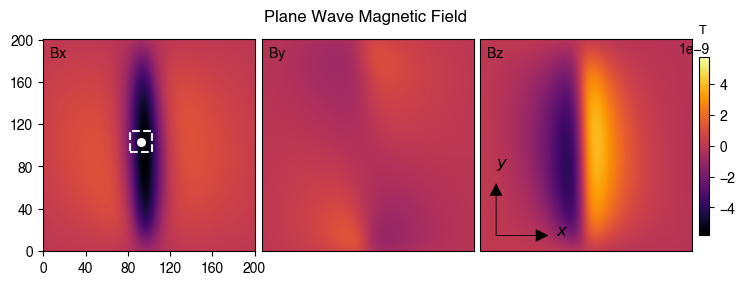

In [6]:
z_sensor = max(z_u) + 4e-3

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

# Center of the slab
x0 = 0.5 * (x_min + x_max)
y0 = 0.5 * (y_min + y_max)

# NV size
FOVx = 5e-2
FOVy = 5e-2

# Resolution
Nx = 201
Ny = 201

bounds = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2, 
          z_sensor, z_sensor)

bounds_xy = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2)

sensor = RegularGridSensor(bounds=bounds, resolution=(Nx, Ny, 1))
obs_pts = sensor.points

B_grid = get_b_from_monopoles_to_grid(gcs, gds, obs_pts, Nx, Ny)

t_idx = 0
Bx, By, Bz = B_grid[0,:,:,t_idx], B_grid[1,:,:,t_idx], B_grid[2,:,:,t_idx]

data=np.stack([Bx,By,Bz], axis=0)

fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field'
)

ax, idx_box = draw_roi_box(fig, roi['bounds'], full_bounds_phys,
                           color='white', lw=1.5, ls='--', alpha=0.95)

plt.draw()

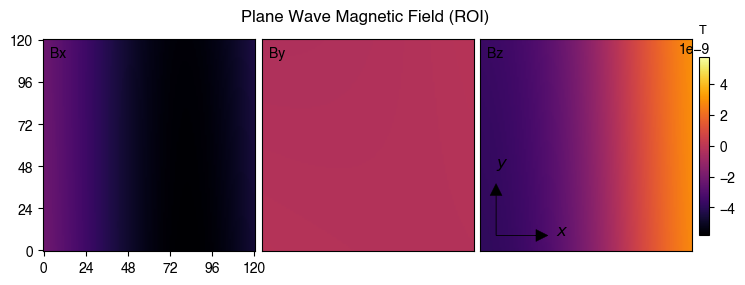

In [7]:
xmin, xmax, ymin, ymax = roi['bounds']
Nx_ROI, Ny_ROI = 121, 121
sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_sensor, z_sensor),
                               resolution=(Nx_ROI, Ny_ROI, 1))
obs_pts_roi = sensor_roi.points

B_truth_roi = get_b_from_monopoles_to_grid(gcs, gds, obs_pts_roi, Nx_ROI, Ny_ROI)
B_truth_roi_t = B_truth_roi[:, :, :, t_idx]     # (3, Nx_ROI, Ny_ROI)

Bx, By, Bz = B_truth_roi_t[0], B_truth_roi_t[1], B_truth_roi_t[2]
data = np.stack([Bx, By, Bz], axis=0)

fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI)'
)

### PCB Geometry 

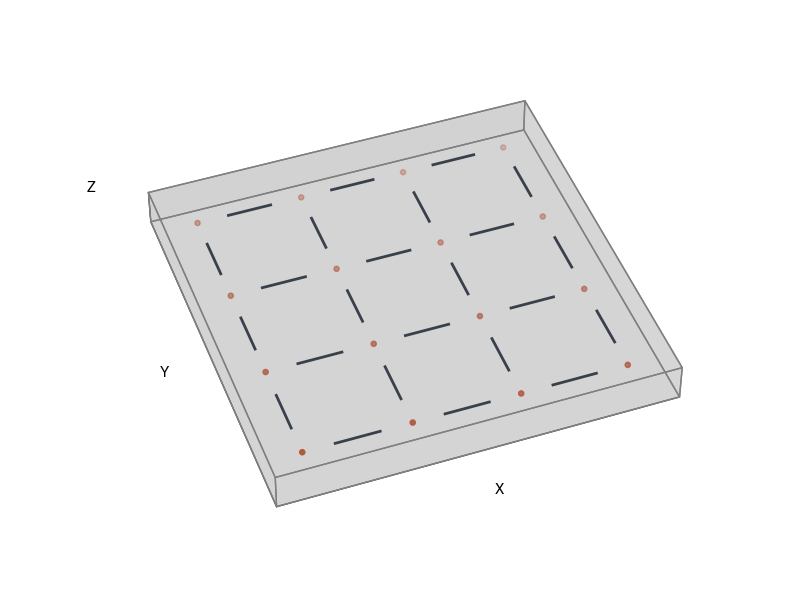

(<Figure size 800x600 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [8]:
%matplotlib widget

edges_full = grid_graph_from_monopoles(gcs_z0)  # uses frame 0; coordinates in meters
edges_roi = filter_edges_in_roi(edges_full, roi['bounds'])
dead_each = 0.4*MM

edges_trim = []

for p_start, q_end in edges_roi:
    ps_trim, qs_trim = central_subsegment(p_start, q_end, dead_each=0.4*MM)

    edges_trim.append([ps_trim.tolist(), qs_trim.tolist()])

bounds_roi = (xmin, xmax, ymin, ymax, min(z_u), max(z_u))

# Take frame 0
grid = gcs_z0[:, :, 0, :]  # (ny, nx, 3)

# Mask centers inside ROI
mask = centers_in_roi_mask(grid, (xmin, xmax, ymin, ymax))

# Apply mask
roi_centers = grid[mask]  # (N_roi, 3)

# Reshape back to (ny, nx, 1, 3) so it matches what the plotting function expects
roi_grid = np.zeros((grid.shape[0], grid.shape[1], 1, 3))
roi_grid[:] = np.nan  # start with NaN so non-ROI centers disappear
roi_grid[mask, 0, :] = roi_centers


plot_geometry(bounds_roi, roi_grid, edges_roi,
                          dead_each=0.4*MM,
                          elev=45, azim=70)

### Current Distribution Reconstruction

<b>Objective:</b> Determine the optimal set of currents $I=[I_1, I_2, ..., I_N]$ flowing through $N$ traces that minimizes the magnetic field error within a defined ROI. The magnetic field error is defined as the difference between the real magnetic field and the one generated from the optimized currents. 

The real magnetic field produced by the monopole approximation is: $$\vec{B}_{\text{truth}} = \frac{\mu_0}{4\pi} \sum_{i}^{\text{voxel}} \left( \sum_{k} \vec{J}_k V_k \times \frac{\vec{r} - \vec{r}_i'}{|\vec{r} - \vec{r}_i'|^3}\right),$$ while the magnetic field produced by the PCB is given by: $$\vec{B}_{\text{PCB}}=\sum_{i}^{N}\frac{\mu_0}{4\pi}\int d\vec{l}\times \frac{\vec{r} - \vec{r}_i'}{|\vec{r} - \vec{r}_i'|^3}=\sum_{i}^{N}A_iI_i.$$ The aim is therefore to find the currents vector $I$ that minimizes the objective function $$e(I)=||AI-B_{\text{truth}}||^2.$$ We denote the matrix $A$ as the <b>Biot-Savart operator</b>, since it allows to map a current distribution in the current space into a magnetic field in the magnetic field space. In the case of a well-posed problem such currents are defined through the <b>Moore-Penrose, or pseudoinverse matrix</b> $$A^{\dagger}=(A^{\text{T}}A)^{-1}A^{\text{T}},$$ so that $$I_{sol}=A^{\dagger}B_{\text{truth}}.$$ Most current distribution reconstruction problems, however, are ill-posed, therefore calling for regularization strategies, such as teh well-known Tikhonov regularization method: $$e(I)=||AI-B_{\text{truth}}||^2+\lambda ||I||^2,$$ leading to Euler's equation: $$I_{sol}=(A^{\text{T}}A+\lambda\text{I})^{-1}A^{\text{T}}B_{\text{truth}}.$$

#### On the well-posedness of the problem

In [71]:
A = get_A_matrix(obs_pts_roi, edges_trim) 

matrix_rank = np.linalg.matrix_rank(A)
num_columns = A.shape[1]

print(f"The rank of the matrix A is: {matrix_rank}")
print(f"The number of columns is: {num_columns}")

if matrix_rank < num_columns:
    print("The matrix is not full rank.")
else:
    print("The matrix is full rank.")

The rank of the matrix A is: 24
The number of columns is: 24
The matrix is full rank.


#### Linear System Solution

In [72]:
B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)

optimal_lambda = 0

A_reg = np.vstack([A, optimal_lambda * np.eye(A.shape[1])])
B_reg = np.vstack([B_truth_vector, np.zeros((A.shape[1], 1))])

I_solution, _, _, _ = np.linalg.lstsq(A_reg, B_reg, rcond=None)

# 5. Compute the optimized magnetic field and plot
edge_I_roi = {}
for i, (p_raw, q_raw) in enumerate(edges_trim):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi[key] = I_solution[i, 0]

B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

B_pcb_vector = B_pcb_grid.reshape(-1)
B_truth_vector_flat = B_truth_roi_t.reshape(-1)

# Calculate the optimal scalar (alpha) to match the magnitudes
alpha = np.dot(B_truth_vector_flat, B_pcb_vector) / np.dot(B_pcb_vector, B_pcb_vector)
print(f"Optimal scaling factor (alpha): {alpha}")

# Scale the final PCB magnetic field
B_pcb_grid_scaled = B_pcb_grid

Optimal scaling factor (alpha): 0.9999999999999958


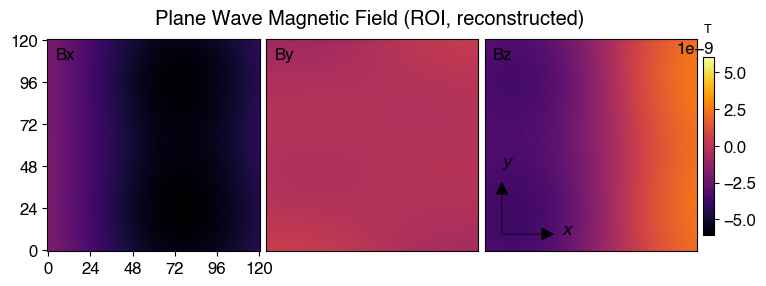

In [75]:
Bx_pcb, By_pcb, Bz_pcb = B_pcb_grid_scaled[0], B_pcb_grid_scaled[1], B_pcb_grid_scaled[2]
data_pcb = np.stack([Bx_pcb, By_pcb, Bz_pcb], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_pcb,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, reconstructed)'
)

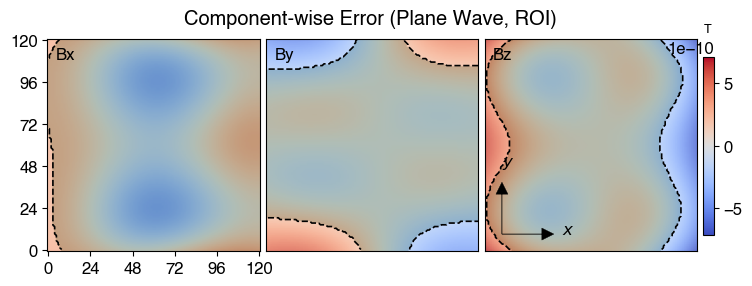

In [76]:
Err = B_pcb_grid_scaled - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

# 3) Plot error maps with a diverging colormap centered at 0
fig_err = plot_n_components(
    Err,
    units='T',
    cmap='coolwarm',
    labels=['Bx', 'By', 'Bz'],  # Corrected labels
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Component-wise Error (Plane Wave, ROI)'
)

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.1 # 10%

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    good_fit_mask = (rel_k.T <= relative_error_threshold) | (np.abs(err_k.T) <= nv_resolution_threshold)

    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.2, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)

plt.draw()

#### Error vs. Distance from the sensor

In [9]:
z_min_mm = 0.1
z_max_mm = 5.0
N_steps = 20
z_distances_m = np.linspace(z_min_mm * MM, z_max_mm * MM, N_steps)

xmin, xmax, ymin, ymax = roi['bounds']
Nx_ROI, Ny_ROI = 121, 121

results = {
    'z_distance': z_distances_m,
    'frac_x': [],
    'frac_y': [],
    'frac_z': []
}

print("Starting Z-Height Reconstruction Accuracy Analysis...")

for z_sensor in z_distances_m:
    z_sens = max(z_u)+z_sensor
    sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_sens, z_sens),
                               resolution=(Nx_ROI, Ny_ROI, 1))
    obs_pts_roi = sensor_roi.points

    B_truth_roi = get_b_from_monopoles_to_grid(gcs, gds, obs_pts_roi, Nx_ROI, Ny_ROI)
    B_truth_roi_t = B_truth_roi[:, :, :, t_idx]     # (3, Nx_ROI, Ny_ROI)
    B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)

    A = get_A_matrix(obs_pts_roi, edges_trim) 
    
    I_solution, _, _, _ = np.linalg.lstsq(A, B_truth_vector, rcond=None)

    edge_I_roi = {}
    for i, (p_raw, q_raw) in enumerate(edges_trim):
        key = undirected_key(np.array(p_raw), np.array(q_raw))
        edge_I_roi[key] = I_solution[i, 0]

    B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

    B_rec_flat = B_pcb_grid.reshape(3, -1)
    B_tru_flat = B_truth_roi_t.reshape(3, -1) 

    # 3.5 Calculate Error Metric
    frac_x, frac_y, frac_z = calculate_area_fraction(B_rec_flat, B_tru_flat, threshold=0.10, abs_threshold=2e-10)

    results['frac_x'].append(frac_x)
    results['frac_y'].append(frac_y)
    results['frac_z'].append(frac_z)
    
    # print(f"Z={z_sensor*1000:.2f}mm -> Bx_frac:{frac_x:.2f}, By_frac:{frac_y:.2f}, Bz_frac:{frac_z:.2f}")

print("Analysis Complete.")


Starting Z-Height Reconstruction Accuracy Analysis...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Analysis Complete.


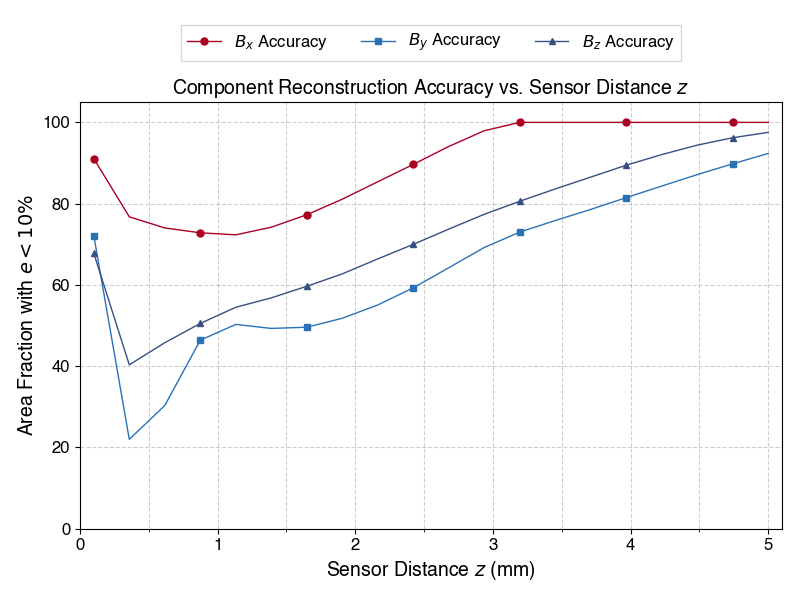

In [10]:
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 1,
    'lines.markersize': 5,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'figure.figsize': (8, 6) # Standard single-column figure size
})

fig, ax = plt.subplots()

colors = {
    'Bz': "#374f82",  # Dark Blue
    'By': '#2972b6',  # Medium Blue
    'Bx': "#aa0024"   # Light Blue
}

z_distances_mm = results['z_distance'] * 1000 # Convert to mm

# Plot Bx
ax.plot(z_distances_mm, results['frac_x'], 
        label=r'$B_x$ Accuracy', 
        color=colors['Bx'], 
        linestyle='-', 
        marker='o', 
        markevery=3)

# Plot By
ax.plot(z_distances_mm, results['frac_y'], 
        label=r'$B_y$ Accuracy', 
        color=colors['By'], 
        linestyle='-', 
        marker='s', 
        markevery=3)

# Plot Bz
ax.plot(z_distances_mm, results['frac_z'], 
        label=r'$B_z$ Accuracy', 
        color=colors['Bz'], 
        linestyle='-', 
        marker='^', 
        markevery=3)

# Add grid and limits
ax.grid(True, which='both')
ax.set_ylim(0, 1.05)
ax.set_xlim(z_distances_mm[0], z_distances_mm[-1]+0.1)

# Labels and Title
ax.set_xlabel('Sensor Distance $z$ (mm)', fontsize=14)
ax.set_ylabel(r'Area Fraction with $e<10\%$', fontsize=14)

# Y-axis ticks to show percentage
yticks = np.linspace(0, 1, 6)
ax.set_yticks(yticks)
ax.set_yticklabels([f'{int(y*100)}' for y in yticks])

ax.set_xticks(np.arange(0, z_max_mm + 1, 1.0))
ax.set_xticks(np.arange(0, z_max_mm + 0.5, 0.5), minor=True)

# Legend
ax.legend(
    loc='upper center',         # Anchor the legend box center-top
    bbox_to_anchor=(0.5, 1.2), # Place it above the plot (y=1.15)
    ncol=3,                     # Display in 3 columns (horizontal)
    # title="Component Accuracy",  # Keep the title
    frameon=True,              # Typically no box when placed outside
    fancybox=False,             # Keep it simple
    shadow=False
)

# Title/Caption style
ax.set_title(r'Component Reconstruction Accuracy vs. Sensor Distance $z$', fontsize=14)

plt.tight_layout()
plt.show()


#### Error vs. Number of edges

In [12]:
FIXED_XMIN = roi_centers[0,0]
FIXED_XMAX = roi_centers[12,0]
FIXED_YMIN = roi_centers[0,1]
FIXED_YMAX = roi_centers[15,1]
FIXED_Z_LEVEL_CENTERS = roi_centers[0,2]
FIXED_BOUNDS = (FIXED_XMIN, FIXED_XMAX, FIXED_YMIN, FIXED_YMAX)
DEAD_LENGTH_RATIO = 0.4 / 1.35 
ROI_SIDE_LENGTH = FIXED_XMAX-FIXED_XMIN

B_tru_flat = B_truth_roi_t.reshape(3, -1) 
B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)

N_min = 2
N_max = 15
N_centers_range = np.linspace(N_min, N_max, N_max-N_min+1, dtype=int)

results_density = {
    'N_centers_per_side': [],
    'N_total_edges': [],
    'frac_x': [],
    'frac_y': [],
    'frac_z': []
}

print("Starting Geometry Density Reconstruction Accuracy Analysis...")

for N_grid in N_centers_range:
    
    # --- 3.0 DYNAMIC DEAD_EACH CALCULATION ---
    # Length of a single edge segment
    L_edge = ROI_SIDE_LENGTH / (N_grid - 1)
    
    # Scale dead_each proportionally (in meters)
    dead_each_scaled = DEAD_LENGTH_RATIO * L_edge 
    
    # 3.1 Generate the Discretized Geometry
    edges_roi, current_centers_grid = generate_grid_geometry(
        FIXED_BOUNDS, 
        N_grid, 
        z_level=FIXED_Z_LEVEL_CENTERS
    )
    
    # 3.1.1 Apply Trimming
    edges_trim = []
    for p_start, q_end in edges_roi:
        ps_trim, qs_trim = central_subsegment(p_start, q_end, dead_each=dead_each_scaled)
        edges_trim.append([ps_trim.tolist(), qs_trim.tolist()])

    N_edges = len(edges_trim)
    
    A = get_A_matrix(obs_pts_roi, edges_trim)

    # 3.3 Solve and Reconstruct (Mock LSQ using mock A-matrix)
    I_solution, _, _, _ = np.linalg.lstsq(A, B_truth_vector, rcond=None)
    
    edge_I_roi = {}
    for i, (p_raw, q_raw) in enumerate(edges_trim):
        key = undirected_key(np.array(p_raw), np.array(q_raw))
        edge_I_roi[key] = I_solution[i, 0]

    B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)
    B_rec_flat = B_pcb_grid.reshape(3, -1)
    
    # 3.4 Calculate Error Metric (Mock)
    frac_x, frac_y, frac_z = calculate_area_fraction(
        B_rec_flat, 
        B_tru_flat, 
        threshold=0.10, 
        abs_threshold=2e-10
    )
    
    # 3.5 Store Results
    results_density['N_centers_per_side'].append(N_grid)
    results_density['N_total_edges'].append(N_edges)
    results_density['frac_x'].append(frac_x)
    results_density['frac_y'].append(frac_y)
    results_density['frac_z'].append(frac_z)
    
    print(f"N_grid={N_grid:02} (Edges={N_edges:03}) -> Bx:{frac_x:.4f}, By:{frac_y:.4f}, Bz:{frac_z:.4f} (Dead Length: {dead_each_scaled*1e6:.1f} um)")

print("Density Analysis Complete.")


Starting Geometry Density Reconstruction Accuracy Analysis...
N_grid=02 (Edges=004) -> Bx:0.9155, By:0.6651, Bz:0.4282 (Dead Length: 1200.0 um)
N_grid=03 (Edges=012) -> Bx:0.9180, By:0.6918, Bz:0.4817 (Dead Length: 600.0 um)
N_grid=04 (Edges=024) -> Bx:0.9110, By:0.7214, Bz:0.6779 (Dead Length: 400.0 um)
N_grid=05 (Edges=040) -> Bx:0.9230, By:0.6782, Bz:0.7040 (Dead Length: 300.0 um)
N_grid=06 (Edges=060) -> Bx:0.9287, By:0.6335, Bz:0.7542 (Dead Length: 240.0 um)
N_grid=07 (Edges=084) -> Bx:0.9232, By:0.5367, Bz:0.7978 (Dead Length: 200.0 um)
N_grid=08 (Edges=112) -> Bx:0.9395, By:0.4920, Bz:0.8415 (Dead Length: 171.4 um)
N_grid=09 (Edges=144) -> Bx:0.9437, By:0.5255, Bz:0.8709 (Dead Length: 150.0 um)
N_grid=10 (Edges=180) -> Bx:0.9503, By:0.5393, Bz:0.8966 (Dead Length: 133.3 um)
N_grid=11 (Edges=220) -> Bx:0.9536, By:0.5418, Bz:0.9036 (Dead Length: 120.0 um)
N_grid=12 (Edges=264) -> Bx:0.9580, By:0.5473, Bz:0.9154 (Dead Length: 109.1 um)
N_grid=13 (Edges=312) -> Bx:0.9643, By:0.5842,

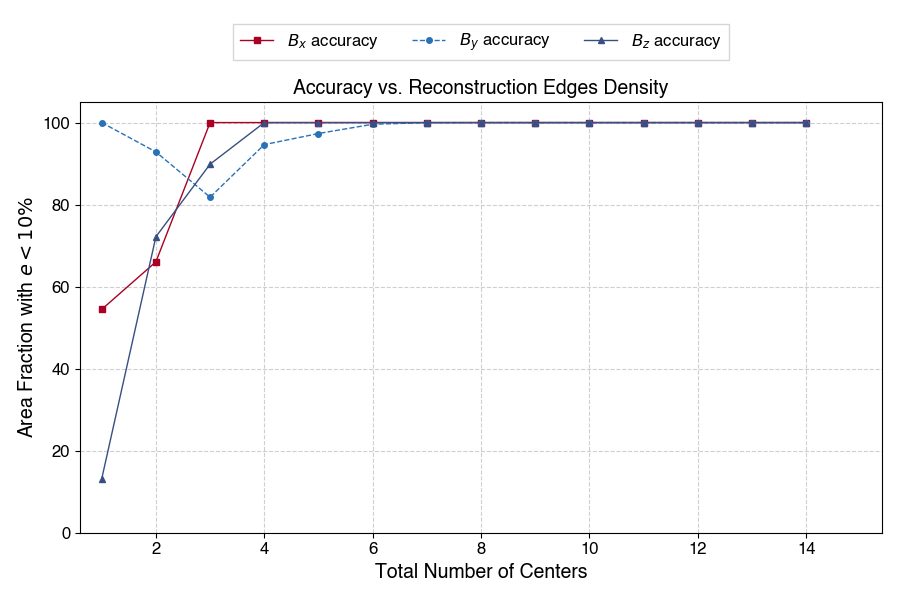

In [ ]:
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 1,
    'lines.markersize': 4,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'figure.figsize': (9, 6) # Wider figure for horizontal legend
})

fig, ax = plt.subplots()

# Define a gradient of blue colors
colors = {
    'Bz': '#374f82',  # Dark Blue
    'By': '#2972b6',  # Medium Blue
    'Bx': '#aa0024'   # Light Blue
}

X_data = np.array(results_density['N_centers_per_side'])

# Plot Bx
ax.plot(X_data, results_density['frac_x'], label=r'$B_x$ accuracy', color=colors['Bx'], linestyle='-', marker='s', markevery=1)
# Plot By
ax.plot(X_data, results_density['frac_y'], label=r'$B_y$ accuracy', color=colors['By'], linestyle='--', marker='o', markevery=1)
# Plot Bz
ax.plot(X_data, results_density['frac_z'], label=r'$B_z$ accuracy', color=colors['Bz'], linestyle='-', marker='^', markevery=1)


# --- AXES AND LABELS ---
ax.grid(True, which='both')
ax.set_ylim(0, 1.05)
ax.set_xlim(X_data.min()-0.4, X_data.max()+0.4)

# X-axis: Logarithmic scale is often useful when iterating over mesh size
# ax.set_xscale('log') # Optional: use if high densities are reached

ax.set_xlabel('Total Number of Centers', fontsize=14)
ax.set_ylabel(r'Area Fraction with $e<10\%$', fontsize=14)

# Y-axis ticks to show percentage
yticks = np.linspace(0, 1, 6)
ax.set_yticks(yticks)
ax.set_yticklabels([f'{int(y*100)}' for y in yticks])

# --- LEGEND (NorthOutside Style) ---
ax.legend(
    loc='upper center',         # Anchor the legend box center-top
    bbox_to_anchor=(0.5, 1.2), # Place it above the plot (y=1.15)
    ncol=3,                     # Display in 3 columns (horizontal)
    # title="Component Accuracy",  # Keep the title
    frameon=True,              # Typically no box when placed outside
    fancybox=False,             # Keep it simple
    shadow=False
)

# Set the title below the legend area
ax.set_title(r'Accuracy vs. Reconstruction Edges Density', fontsize=14)


plt.tight_layout()
plt.show()
plt.savefig('accuracy_vs_density.png', dpi=300, bbox_inches='tight')

#### Performance Map

In [14]:
N_min = 2
N_max = 15
N_centers_range = np.linspace(N_min, N_max, N_max-N_min+1, dtype=int)
N_DENSITY_STEPS = len(N_centers_range) # 14

z_min_mm = 0.1
z_max_mm = 5.0

z_distances_m = np.linspace(z_min_mm * MM, z_max_mm * MM, 20) 
N_Z_STEPS = len(z_distances_m) # 20


accuracy_map_x = np.zeros((N_Z_STEPS, N_DENSITY_STEPS))
accuracy_map_y = np.zeros((N_Z_STEPS, N_DENSITY_STEPS))
accuracy_map_z = np.zeros((N_Z_STEPS, N_DENSITY_STEPS))

for i, z_sensor in enumerate(z_distances_m):
    
    
    z_fixed = max(z_u) + z_sensor
    
   
    sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_fixed, z_fixed),
                               resolution=(Nx_ROI, Ny_ROI, 1))
    obs_pts_roi = sensor_roi.points

    B_truth_roi = get_b_from_monopoles_to_grid(gcs, gds, obs_pts_roi, Nx_ROI, Ny_ROI)
    B_truth_roi_t = B_truth_roi[:, :, :, t_idx]
    
    B_tru_flat = B_truth_roi_t.reshape(3, -1) 
    B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)
    
    
    for j, N_grid in enumerate(N_centers_range):

        L_edge = ROI_SIDE_LENGTH / (N_grid - 1)
        dead_each_scaled = DEAD_LENGTH_RATIO * L_edge 
        
        edges_roi, current_centers_grid = generate_grid_geometry(
            FIXED_BOUNDS, 
            N_grid, 
            z_level=FIXED_Z_LEVEL_CENTERS
        )

        edges_trim = []
        for p_start, q_end in edges_roi:
            ps_trim, qs_trim = central_subsegment(p_start, q_end, dead_each=dead_each_scaled)
            edges_trim.append([ps_trim.tolist(), qs_trim.tolist()])
        
        A = get_A_matrix(obs_pts_roi, edges_trim) 
        I_solution, _, _, _ = np.linalg.lstsq(A, B_truth_vector, rcond=None)
        
        edge_I_roi = {}
        for idx, (p_raw, q_raw) in enumerate(edges_trim):
            key = undirected_key(np.array(p_raw), np.array(q_raw))
            edge_I_roi[key] = I_solution[idx, 0]

        B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)
        B_rec_flat = B_pcb_grid.reshape(3, -1)
    
        frac_x, frac_y, frac_z = calculate_area_fraction(
            B_rec_flat,
            B_tru_flat,
            threshold=0.1,
            abs_threshold=2e-10
        )
        
        accuracy_map_x[i, j] = frac_x
        accuracy_map_y[i, j] = frac_y
        accuracy_map_z[i, j] = frac_z
        
print("2D sweep complete.")

2D sweep complete.


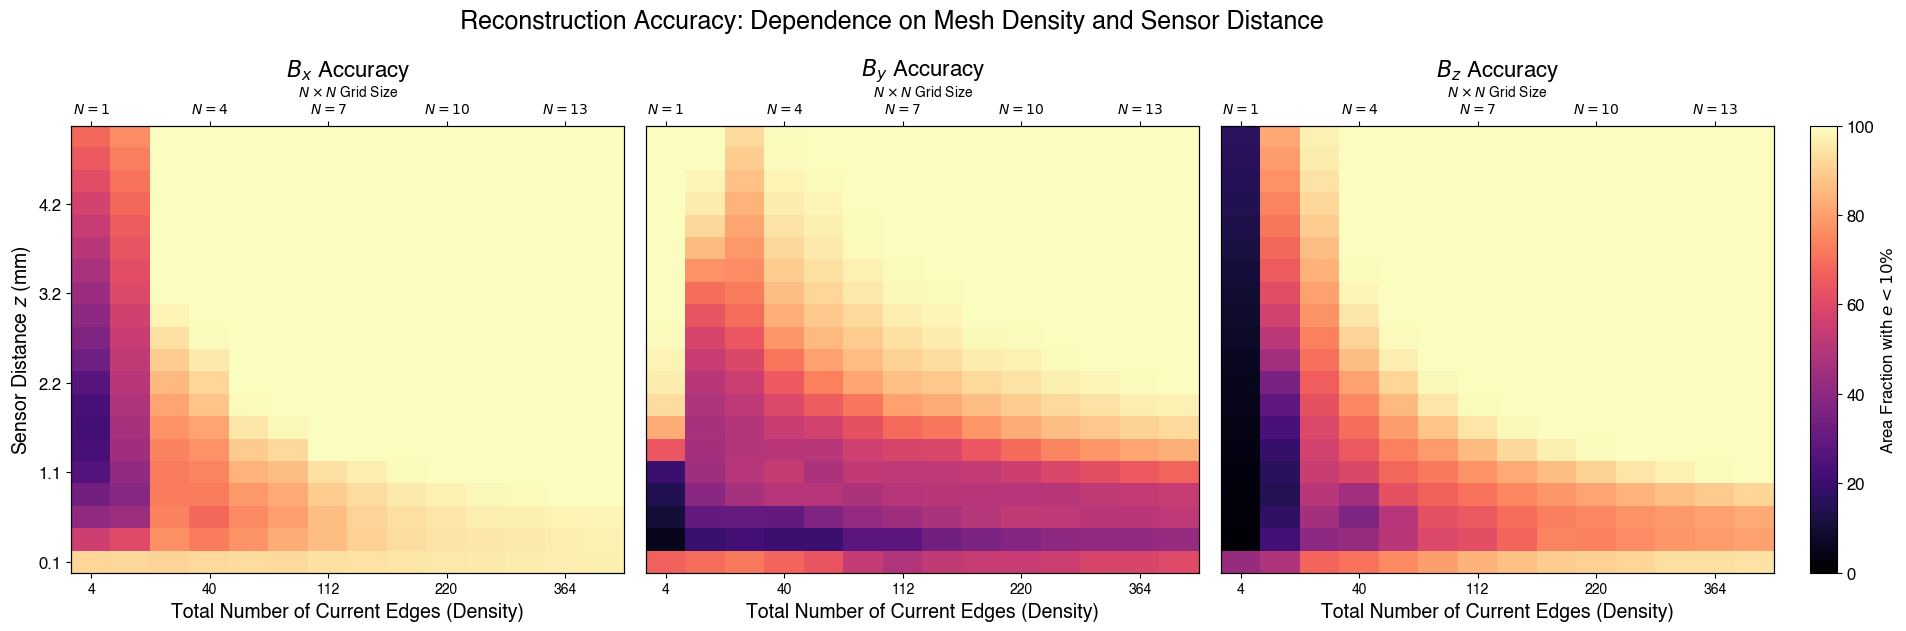

In [25]:
%matplotlib inline 

accuracy_data = {
    r'$B_x$ Accuracy': accuracy_map_x,
    r'$B_y$ Accuracy': accuracy_map_y,
    r'$B_z$ Accuracy': accuracy_map_z,
}

X_TOTAL_EDGES = 2 * N_centers_range * (N_centers_range - 1) 
Y_Z_DISTANCES_MM = z_distances_m * 1000

plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 10,
    'ytick.labelsize': 12,
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cbar_ticks = np.linspace(0, 1, 6) 
cmap = 'magma'

im = None

N_steps_to_show = 3
N_indices = np.arange(N_DENSITY_STEPS) 
N_indices_to_show = N_indices[::N_steps_to_show] 

Y_indices = np.arange(N_Z_STEPS)
Y_steps_to_show = 4 
Y_indices_to_show = Y_indices[::Y_steps_to_show]
Y_labels_mm = Y_Z_DISTANCES_MM[Y_indices_to_show]


for ax_idx, (title, data_map) in enumerate(accuracy_data.items()):
    ax = axes[ax_idx]
    
    im = ax.imshow(
        data_map, 
        origin='lower', 
        aspect='auto',
        cmap=cmap,
        vmin=0.0, 
        vmax=1.0,
    )

    ax.set_xlabel('Total Number of Current Edges (Density)', fontsize=14)
    
    ax.set_xticks(N_indices_to_show)
    
    N_total_edges_labels = X_TOTAL_EDGES[N_indices_to_show]
    ax.set_xticklabels([f'{e}' for e in N_total_edges_labels])

    if ax_idx == 0:
        ax.set_ylabel('Sensor Distance $z$ (mm)', fontsize=14)
        
        ax.set_yticks(Y_indices_to_show)
        
        ax.set_yticklabels([f'{y:.1f}' for y in Y_labels_mm])
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    ax2 = ax.twiny()
    
    ax2.set_xlim(ax.get_xlim()) 
    
    ax2.set_xticks(N_indices_to_show)
    
    N_center_labels = N_centers_range[N_indices_to_show]
    ax2.set_xticklabels([f'$N={N}$' for N in N_center_labels-1])
    ax2.set_xlabel('$N \\times N$ Grid Size', fontsize=10)

    ax.set_title(title, fontsize=16)

plt.tight_layout()

cax = fig.add_axes([1.01, axes[0].get_position().y0, 0.015, axes[0].get_position().height])

cbar = fig.colorbar(
im,
cax=cax, # Use the dedicated axis
orientation='vertical',
ticks=cbar_ticks
)

cbar.set_label(r'Area Fraction with $e<10\%$', fontsize=12)
cbar.set_ticklabels([f'{int(t*100)}' for t in cbar_ticks])

plt.suptitle('Reconstruction Accuracy: Dependence on Mesh Density and Sensor Distance', fontsize=18, y=1.05)

plt.show()

In [17]:
j_N4 = 2  # Index for N_grid = 4

print("--- N_grid=4 (j=2) Z-Distance Sweep Data ---")
print(f"Z-distances (mm): {z_distances_m[:5]*1000}...")

print("\nBx Accuracy (Column j=2):")
# This shows the Bx accuracy for N_grid=4, across all 20 Z-steps (i=0 to i=19)
print(accuracy_map_x[:, j_N4]) 

print("\nBz Accuracy (Column j=2):")
print(accuracy_map_z[:, j_N4])

# Check the first value (minimum Z-distance)
print(f"\nAccuracy at z_min={z_distances_m[0]*1000:.2f}mm:")
print(f"Bx: {accuracy_map_x[0, j_N4]:.3f}, Bz: {accuracy_map_z[0, j_N4]:.3f}")

--- N_grid=4 (j=2) Z-Distance Sweep Data ---
Z-distances (mm): [0.1        0.35789474 0.61578947 0.87368421 1.13157895]...

Bx Accuracy (Column j=2):
[0.91100335 0.76763882 0.74018168 0.72829725 0.72324295 0.74202582
 0.77262482 0.81101018 0.85383512 0.89666006 0.94071443 0.97944129
 1.         1.         1.         1.         1.         1.
 1.         1.        ]

Bz Accuracy (Column j=2):
[0.67789085 0.40338775 0.45775562 0.50522505 0.54497644 0.56813059
 0.59661225 0.62714295 0.66402568 0.69981559 0.73738133 0.77378594
 0.80588758 0.83621337 0.86537805 0.89461102 0.92077044 0.9439929
 0.96222936 0.97547982]

Accuracy at z_min=0.10mm:
Bx: 0.911, Bz: 0.678


### Integrating current loops in the ROI

#### PCB Geometry (with loops)

In [ ]:
edges_full = grid_graph_from_monopoles(gcs_z0) 
edges_roi = filter_edges_in_roi(edges_full, roi['bounds'])
dead_each = 0.4*MM

bounds_roi = (xmin, xmax, ymin, ymax, min(z_u), max(z_u))

# Take frame 0
grid = gcs_z0[:, :, 0, :]  # (ny, nx, 3)

# Mask centers inside ROI
mask = centers_in_roi_mask(grid, (xmin, xmax, ymin, ymax))

# Apply mask
roi_centers = grid[mask]  # (N_roi, 3)

# Reshape back to (ny, nx, 1, 3) so it matches what the plotting function expects
roi_grid = np.zeros((grid.shape[0], grid.shape[1], 1, 3))
roi_grid[:] = np.nan  # start with NaN so non-ROI centers disappear
roi_grid[mask, 0, :] = roi_centers

ny_squares, nx_squares, _ = grid.shape
all_square_centers = (grid[:ny_squares-1, :nx_squares-1, :] +
                      grid[1:, :nx_squares-1, :] +
                      grid[:ny_squares-1, 1:, :] +
                      grid[1:, 1:, :]) / 4.0

# --- Filter to find only the square centers in the ROI (CORRECTED LOGIC) ---
mask_x = (all_square_centers[..., 0] >= xmin) & (all_square_centers[..., 0] <= xmax)
mask_y = (all_square_centers[..., 1] >= ymin) & (all_square_centers[..., 1] <= ymax)

# Combine masks to find squares with centers fully inside the ROI
roi_square_centers = all_square_centers[mask_x & mask_y]

# Reshape the array to a list of coordinates
square_centers = roi_square_centers.reshape(-1, 3)

loop_radius = 0.5e-3  # A radius of 45% of the grid spacing

# Create a list to store the loop information
loops_roi = []

# Iterate through each center in the ROI and create a loop
for center_coords in square_centers:
    # We define each loop by its center coordinates and its radius
    # The z-coordinate of the loop is the same as its center
    loop_info = {
        'center_x': center_coords[0],
        'center_y': center_coords[1],
        'center_z': center_coords[2],
        'radius': loop_radius
    }
    loops_roi.append(loop_info)


plot_geometry(bounds_roi, roi_grid, edges_roi,
                          dx_s=1.35e-3, dy_s=1.35e-3,
                          dead_each=0.4*MM,
                          elev=45, azim=70, loops=loops_roi)   # set a small int to declutter

In [ ]:
import numpy as np
from numba import njit, float64, prange

import numpy as np
from numba import njit, float64, prange

@njit(float64(float64))
def ellipk_agm(m):
    # Complete elliptic integral of the first kind K(m)
    if m >= 1.0:
        return np.inf
    a = 1.0
    b = np.sqrt(1.0 - m)
    while True:
        a_n = 0.5 * (a + b)
        b_n = np.sqrt(a * b)
        if np.abs(a_n - a) < 1e-15:
            return np.pi / (2.0 * a_n)
        a = a_n
        b = b_n

@njit(float64(float64))
def ellipe_agm(m):
    # Complete elliptic integral of the second kind E(m)
    if m >= 1.0:
        return 1.0
    a = 1.0
    b = np.sqrt(1.0 - m)
    c = np.sqrt(m)
    S = 0.0
    while True:
        a_n = 0.5 * (a + b)
        b_n = np.sqrt(a * b)
        c_n = 0.5 * (a - b)
        S_n = S + c * a
        if np.abs(a_n - a) < 1e-15:
            return S_n + (np.pi * a_n * c_n) / (2.0 * b_n)
        a = a_n
        b = b_n
        c = c_n
        S = S_n

@njit(parallel=True)
def get_b_njit_loop(loop_center, loop_radius, obs_pts, current=1.0):
    mu_0 = 4.0 * np.pi * 1e-7
    R = loop_radius
    N_sensors = obs_pts.shape[0]

    B_x = np.zeros(N_sensors, dtype=np.float64)
    B_y = np.zeros(N_sensors, dtype=np.float64)
    B_z = np.zeros(N_sensors, dtype=np.float64)
    
    eps = 1e-15

    for i in prange(N_sensors):
        x = obs_pts[i, 0] - loop_center[0]
        y = obs_pts[i, 1] - loop_center[1]
        z = obs_pts[i, 2] - loop_center[2]
        
        rho_sq = x*x + y*y
        rho = np.sqrt(rho_sq)
        
        # Add a small epsilon to the denominator to prevent division by zero
        denom = (R + rho)
        denom = denom*denom + z*z + eps
        k2 = (4.0 * R * rho) / denom

        # Clamp k^2 into a safe range for the elliptic integrals
        if k2 < 0.0:
            k2 = 0.0
        elif k2 > 1.0:
            k2 = 1.0 - 1e-15

        K = ellipk_agm(k2)
        E = ellipe_agm(k2)
        
        c = mu_0 / (2.0 * np.pi)
        gamma = 1.0 / np.sqrt(denom)

        denom2 = (R - rho)
        denom2 = denom2*denom2 + z*z + eps

        B_rho_temp = (E * (R*R + rho_sq + z*z) / denom2 - K)
        B_z_temp   = (K + E * (R*R - rho_sq - z*z) / denom2)

        if rho < 1e-12:
            B_x[i] = 0.0
            B_y[i] = 0.0
            B_z[i] = (mu_0 * current * R*R) / (2.0 * (R*R + z*z + eps)**1.5)
        else:
            B_rho = c * gamma * current * (z / (rho + eps)) * B_rho_temp
            B_z_final = c * gamma * current * B_z_temp
            B_x[i] = B_rho * (x / (rho + eps))
            B_y[i] = B_rho * (y / (rho + eps))
            B_z[i] = B_z_final
            
    return np.stack((B_x, B_y, B_z), axis=1)

def get_A_loops_matrix(obs_pts, loops_roi):
    N_sensors = obs_pts.shape[0]
    N_loops = len(loops_roi)
    A_loops = np.zeros((3 * N_sensors, N_loops), dtype=np.float64)
    unit_current = 1.0

    obs_pts_f64 = np.ascontiguousarray(obs_pts, dtype=np.float64)

    for j, loop_info in enumerate(loops_roi):
        center = np.array(
            [loop_info['center_x'], loop_info['center_y'], loop_info['center_z']],
            dtype=np.float64
        )
        radius = float(loop_info['radius'])

        B_field = get_b_njit_loop(center, radius, obs_pts_f64, current=unit_current)
        A_loops[:, j] = B_field.ravel()

    return A_loops


In [ ]:
A_edges = get_A_matrix(obs_pts_roi, edges_roi)

A_loop = get_A_loops_matrix(obs_pts_roi, loops_roi)

A = np.hstack([A_edges, A_loop])

In [ ]:
optimal_lambda = 0.0 

B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)

A_reg = np.vstack([A, optimal_lambda * np.eye(A.shape[1])])
B_reg = np.vstack([B_truth_vector, np.zeros((A.shape[1], 1))])

I_solution, _, _, _ = np.linalg.lstsq(A_reg, B_reg, rcond=None)

N_edges = A_edges.shape[1]
currents_edges = I_solution[:N_edges, 0]
currents_loops = I_solution[N_edges:, 0]

edge_I_roi = {}
for i, (p_raw, q_raw) in enumerate(edges_roi):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi[key] = currents_edges[i]

B_pcb_edges_grid = get_b_from_edges_to_grid(edges_roi, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

B_pcb_loops_grid_raw = np.zeros(obs_pts_roi.shape, dtype=np.float64)
for i, loop_info in enumerate(loops_roi):
    center = np.array([loop_info['center_x'], loop_info['center_y'], loop_info['center_z']])
    radius = loop_info['radius']
    current = currents_loops[i]
    

    B_loop_field = get_b_njit_loop(center, radius, obs_pts_roi, current=current)
    
    
    B_pcb_loops_grid_raw += B_loop_field

B_pcb_loops_grid = B_pcb_loops_grid_raw.T.reshape(3, Nx_ROI, Ny_ROI)


B_pcb_total_grid = B_pcb_edges_grid + B_pcb_loops_grid

B_pcb_total_vector = B_pcb_total_grid.ravel()
B_truth_vector_flat = B_truth_roi_t.ravel()

alpha = np.dot(B_truth_vector_flat, B_pcb_total_vector) / np.dot(B_pcb_total_vector, B_pcb_total_vector)
print(f"Optimal scaling factor (alpha): {alpha}")

# 8. Scale the final magnetic field
B_pcb_grid_scaled = B_pcb_total_grid * alpha

In [ ]:
loop_center = np.array([0.0, 0.0, 0.0], dtype=np.float64)
loop_radius = 1e-3 # 1 cm radius
current = 1.0

# Define the sensor grid parameters
Nx = 100
Ny = 100
z_sensor = 0.1e-3 # 2 cm above the loop plane

# Define the field of view (FOV)
FOV_size = 0.02 # 5 cm side length

x_min = loop_center[0] - FOV_size / 2
x_max = loop_center[0] + FOV_size / 2
y_min = loop_center[1] - FOV_size / 2
y_max = loop_center[1] + FOV_size / 2

# Create a meshgrid for the x and y coordinates
x_coords = np.linspace(x_min, x_max, Nx)
y_coords = np.linspace(y_min, y_max, Ny)
xx, yy = np.meshgrid(x_coords, y_coords, indexing='ij')

# Create the full grid of observation points (Nx*Ny, 3)
obs_pts_grid = np.zeros((Nx * Ny, 3), dtype=np.float64)
obs_pts_grid[:, 0] = xx.ravel()
obs_pts_grid[:, 1] = yy.ravel()
obs_pts_grid[:, 2] = z_sensor

print("Computing magnetic field for the dummy loop...")
B_field_raw = get_b_njit_loop(loop_center, loop_radius, obs_pts_grid, current)

# Reshape the field to the correct grid format for plotting (3, Nx, Ny)
B_field_grid = B_field_raw.T.reshape(3, Nx, Ny)

plot_n_components(B_field_grid)

In [ ]:
import magpylib as mp

loop_mp = mp.current.Circle(
    current=current, 
    diameter=2 * loop_radius, 
    position=loop_center
)
B_magpylib = loop_mp.getB(obs_pts_grid)

In [ ]:
print("--- Magnetic Field Comparison ---")
print(f"Loop Radius: {loop_radius} m, Current: {current} A")
print(f"Observation Points:\n{obs_pts}")

# Calculate the absolute difference
absolute_diff = np.abs(B_field_raw - B_magpylib)
print("\nAbsolute Difference:\n", absolute_diff)

# Calculate the relative error (handle potential division by zero for B-field of 0)
relative_error = np.abs(B_field_raw - B_magpylib) / np.abs(B_magpylib + 1e-15)
print("\nRelative Error:\n", relative_error)

# Check if the results are close
if np.allclose(B_field_raw, B_magpylib, atol=1e-12, rtol=1e-8):
    print("\n✅ The results are in excellent agreement!")
else:
    print("\n❌ The results show a significant difference. Please check your `get_b_njit_loop` function.")

In [ ]:
Bx_pcb, By_pcb, Bz_pcb = B_pcb_grid_scaled[0], B_pcb_grid_scaled[1], B_pcb_grid_scaled[2]
data_pcb = np.stack([Bx_pcb, By_pcb, Bz_pcb], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_pcb,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, pcb)'
)

In [ ]:
Err = B_pcb_grid_scaled - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

# 3) Plot error maps with a diverging colormap centered at 0
fig_err = plot_n_components(
    Err,
    units='T',
    cmap='coolwarm',
    labels=['Bx', 'By', 'Bz'],  # Corrected labels
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Component-wise Error (Plane Wave, ROI)'
)

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.1

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    good_fit_mask = (rel_k.T <= relative_error_threshold) | (np.abs(err_k.T) <= nv_resolution_threshold)

    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.2, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)

plt.draw()

### Spiral data

In [77]:
N = 121203 # Number of points
T = 151 # Time steps

# shape is (N, 3*T)
current_density_series_flat = np.loadtxt("/Users/ValerioDeSio/Desktop/PythonThesis/current_density_series2.csv", delimiter=",")

# Reshape to (N, 3, T)
cds = current_density_series_flat.reshape(N, 3, T, order="F")  # ← key fix

pts = np.loadtxt("/Users/ValerioDeSio/Desktop/PythonThesis/pts2.csv", delimiter=",")

# unique sorted coordinates
x_u = np.unique(np.round(pts[:,0], 12))
y_u = np.unique(np.round(pts[:,1], 12))
z_u = np.unique(np.round(pts[:,2], 12))

# grid spacings (robust: median of diffs)
dx = np.median(np.diff(x_u))
dy = np.median(np.diff(y_u))
dz = np.median(np.diff(z_u))

volume_element = dx*dy*dz

print(pts.shape)
print(cds.shape)

(121203, 3)
(121203, 3, 151)


In [78]:
%matplotlib inline

dx=1.35e-3
dy=dx
dz=max(z_u)

gds, gcs = get_grid_multipole_expansion_time_3d_pad(
    cds,
    pts,
    cell_size=(dx,dy,dz),  # 3D grid spec (x, y,z)
    volume_element=volume_element
)

# Mask for z=0.0001 plane (midplane)
mask_z0 = np.isclose(pts[:, 2], 0.0001, atol=1e-12)

# Apply mask
pts_z0 = pts[mask_z0]
cds_z0 = cds[mask_z0]  # shape: (N_z0, 3, T)

z_centers = gcs[:, :, :, 0, 2]
z_idx = np.where(np.isclose(z_centers[0, 0, :], 0.0001, atol=1e-12))[0]
z_idx = z_idx[0]

gds_z0 = gds[:, :, z_idx, :, :]
gcs_z0 = gcs[:, :, z_idx, :, :]

edges = grid_graph_from_monopoles(gcs_z0)

bounds = (min(x_u), max(x_u), min(y_u), max(y_u), min(z_u), max(z_u))

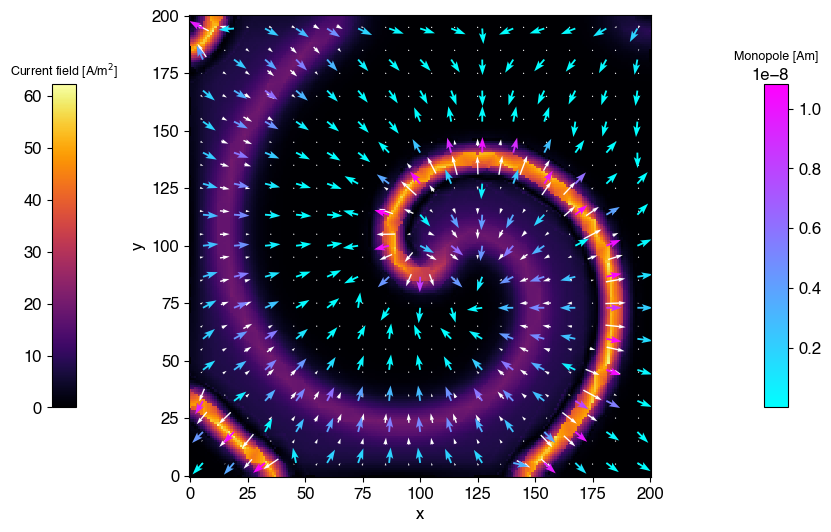

In [79]:
t_idx = 150 # Change according to the time step we evaluate
cds_t = cds_z0[:,:,t_idx]
gds_t = gds_z0[:,:,t_idx]
gcs_t = gcs_z0[:,:,t_idx]

xs_unique = np.unique(np.round(pts_z0[:, 0], 12))
ys_unique = np.unique(np.round(pts_z0[:, 1], 12))

grid_centers_idx = rescale_centers_to_index(gcs_t, xs_unique, ys_unique)

plot_vector_field_2d_monopoles(GridSampler.pts_to_grid(cds_t, 201, 201)[0:2, :, :], gds_t, grid_centers_idx, color='white', units=r'A/m$^2$', units_mono=r'Am', monopole_cmap='cool', cmap='inferno')

ROI center (m): (np.float64(0.003375000000000001), np.float64(0.003375000000000001))
ROI bounds (m): (np.float64(0.0008750000000000008), np.float64(0.005875000000000001), np.float64(0.0008750000000000008), np.float64(0.005875000000000001))


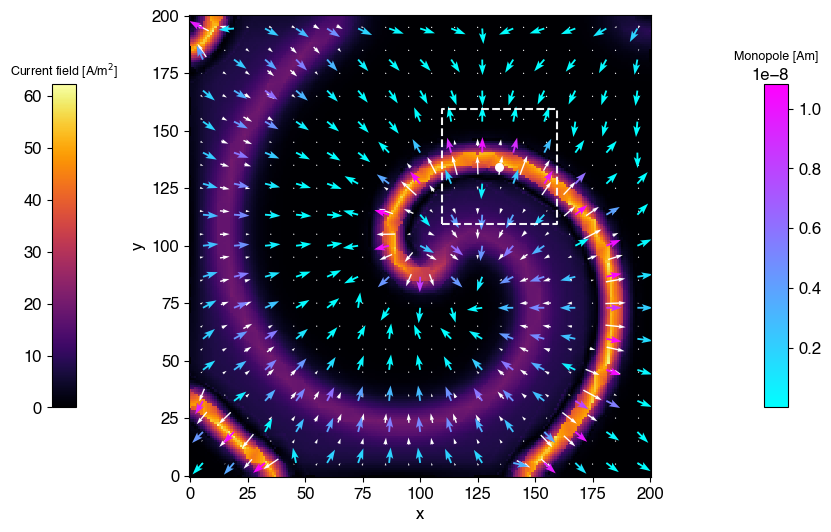

In [80]:
nx, ny = gcs_t.shape[:2]

# Build dictionary
centers_idxed, lookup = index_grid_centers(gcs_t.reshape(nx*ny,3), nx, ny, one_based=True)

p1 = lookup[(10,11)]
p2 = lookup[(11,10)]

roi = roi_from_center(p1, p2)
print("ROI center (m):", roi['center'])
print("ROI bounds (m):", roi['bounds'])

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

full_bounds_phys = (x_min, x_max, y_min, y_max)

fig = plot_vector_field_2d_monopoles(
    GridSampler.pts_to_grid(cds_t, 201, 201)[0:2, :, :],
    gds_t,
    grid_centers_idx,
    color='white',
    units=r'A/m$^2$',
    units_mono=r'Am',
    monopole_cmap='cool',
    cmap='inferno',
    show=True   # important: keep the figure open for overlays
)

ax, idx_box = draw_roi_box(fig, roi['bounds'], full_bounds_phys,
                           color='white', lw=1.5, ls='--', alpha=0.95)

plt.draw()

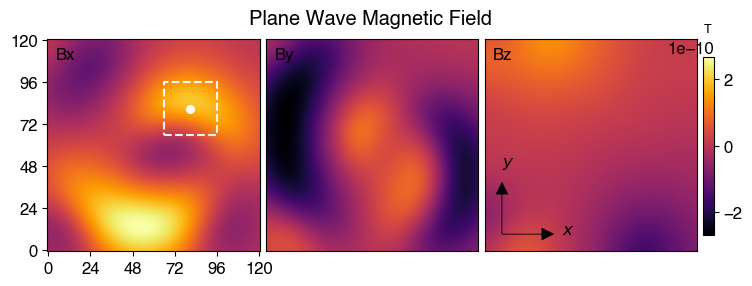

In [81]:
z_sensor = 4e-3

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

# Center of the slab
x0 = 0.5 * (x_min + x_max)
y0 = 0.5 * (y_min + y_max)

# NV size
FOVx = 2e-2
FOVy = 2e-2

# Resolution
Nx = 121
Ny = 121

bounds = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2, 
          z_sensor, z_sensor)

bounds_xy = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2)

sensor = RegularGridSensor(bounds=bounds, resolution=(Nx, Ny, 1))
obs_pts = sensor.points

B_grid = get_b_from_monopoles_to_grid(gcs, gds, obs_pts, Nx, Ny)

t_idx = 150
Bx, By, Bz = B_grid[0,:,:,t_idx], B_grid[1,:,:,t_idx], B_grid[2,:,:,t_idx]

data=np.stack([Bx,By,Bz], axis=0)

fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field'
)

ax, idx_box = draw_roi_box(fig, roi['bounds'], full_bounds_phys,
                           color='white', lw=1.5, ls='--', alpha=0.95)

plt.draw()



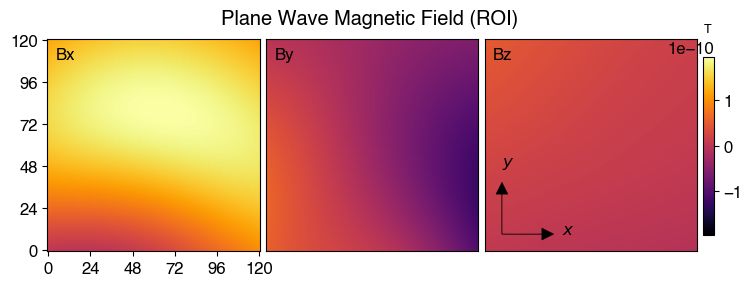

In [82]:
xmin, xmax, ymin, ymax = roi['bounds']
Nx_ROI, Ny_ROI = 121, 121
sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_sensor, z_sensor),
                               resolution=(Nx_ROI, Ny_ROI, 1))
obs_pts_roi = sensor_roi.points

B_truth_roi = get_b_from_monopoles_to_grid(gcs, gds, obs_pts_roi, Nx_ROI, Ny_ROI)
B_truth_roi_t = B_truth_roi[:, :, :, t_idx]     # (3, Nx_ROI, Ny_ROI)

Bx, By, Bz = B_truth_roi_t[0], B_truth_roi_t[1], B_truth_roi_t[2]
data = np.stack([Bx, By, Bz], axis=0)

fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI)'
)

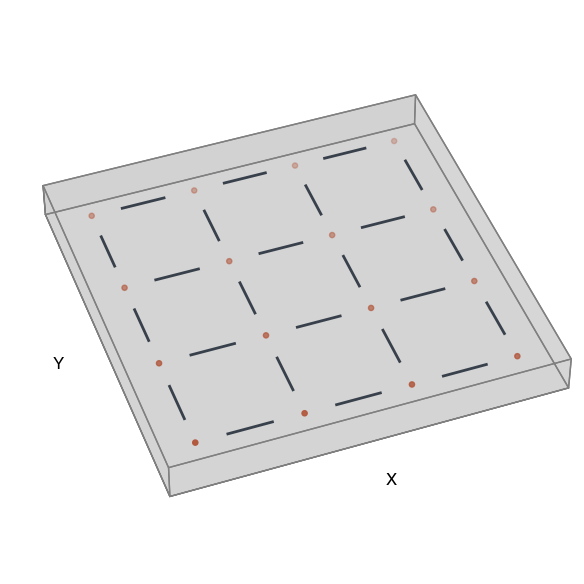

(<Figure size 800x600 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [83]:
edges_full = grid_graph_from_monopoles(gcs_z0)  # uses frame 0; coordinates in meters
edges_roi = filter_edges_in_roi(edges_full, roi['bounds'])
dead_each = 0.4*MM

bounds_roi = (xmin, xmax, ymin, ymax, min(z_u), max(z_u))

# Take frame 0
grid = gcs_z0[:, :, 0, :]  # (ny, nx, 3)

# Mask centers inside ROI
mask = centers_in_roi_mask(grid, (xmin, xmax, ymin, ymax))

# Apply mask
roi_centers = grid[mask]  # (N_roi, 3)

# Reshape back to (ny, nx, 1, 3) so it matches what the plotting function expects
roi_grid = np.zeros((grid.shape[0], grid.shape[1], 1, 3))
roi_grid[:] = np.nan  # start with NaN so non-ROI centers disappear
roi_grid[mask, 0, :] = roi_centers


plot_geometry(bounds_roi, roi_grid, edges_roi,
                          dead_each=0.4*MM,
                          elev=45, azim=70)   # set a small int to declutter

In [85]:
A = get_A_matrix(obs_pts_roi, edges_roi)

I_time_series = []
B_pcb_time_series = []
alpha_time_series = []

B_truth_time_series = B_truth_roi.reshape(-1, 151)

num_time_steps = B_truth_time_series.shape[1]

# Perform regularization for each time step
for t_idx in range(num_time_steps):
    B_truth_vector = B_truth_time_series[:, t_idx].reshape(-1, 1)

    # 3. Apply Tikhonov regularization and solve
    A_reg = np.vstack([A, optimal_lambda * np.eye(A.shape[1])])
    B_reg = np.vstack([B_truth_vector, np.zeros((A.shape[1], 1))])

    I_solution, _, _, _ = np.linalg.lstsq(A_reg, B_reg, rcond=None)
    I_time_series.append(I_solution.flatten())

    # 4. Compute the magnetic field from the reconstructed currents
    edge_I_roi = {}
    for i, (p_raw, q_raw) in enumerate(edges_roi):
        key = undirected_key(np.array(p_raw), np.array(q_raw))
        edge_I_roi[key] = I_solution[i, 0]

    B_pcb_grid = get_b_from_edges_to_grid(edges_roi, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

    # 5. Calculate the optimal scaling factor for this time step
    B_pcb_vector = B_pcb_grid.reshape(-1)
    B_truth_vector_flat = B_truth_vector.reshape(-1)

    alpha = np.dot(B_truth_vector_flat, B_pcb_vector) / np.dot(B_pcb_vector, B_pcb_vector)
    alpha_time_series.append(alpha)

    # Scale the final PCB magnetic field and store
    B_pcb_grid_scaled = B_pcb_grid * alpha
    B_pcb_time_series.append(B_pcb_grid_scaled)

# Convert lists to NumPy arrays for easy access
I_time_series = np.array(I_time_series)
B_pcb_time_series = np.array(B_pcb_time_series)
alpha_time_series = np.array(alpha_time_series)

In [ ]:
edge_of_interest_idx = 10 

# Select the current data for the specific edge.
# The first dimension (rows) is time, and the second (columns) is the edge.
current_of_interest = I_time_series[:, edge_of_interest_idx]

# Plot the current over time
plt.figure(figsize=(10, 6))
plt.plot(current_of_interest)
plt.xlabel('Time (s)')
plt.ylabel(f'Current (A) on Edge {edge_of_interest_idx}')
plt.title(f'Reconstructed Current over Time for Edge {edge_of_interest_idx}')
plt.grid(True)
plt.show()